## Trying with Resnet classifier

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as ts

Using TensorFlow backend.


In [2]:

# encoding_dim = 32

input_img = Input(shape=(64, 64, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) #16
x = AveragePooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) #8
x = AveragePooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
                
x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(encoded)
x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
images = np.load('humans_64.npy')

In [4]:
images = images.astype('float32') / 255.
images.shape

(13233, 64, 64, 3)

In [5]:

x_train = images[0:5000]
x_test = images[5000:6000]

x_train = np.reshape(x_train, (len(x_train), 64, 64, 3))  
x_test = np.reshape(x_test, (len(x_test), 64, 64, 3)) 


In [6]:
print(x_train.shape)
print(x_test.shape)

(5000, 64, 64, 3)
(1000, 64, 64, 3)


In [7]:
# To save memory space!
images=None


In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model_ = ResNet50(weights='imagenet')

In [23]:
# Define custom loss

from keras import losses

def custom_loss(layer):           
     
    def loss(y_true, y_pred):
        
        resnet = ResNet50_model_(y_pred)
       
        pred = ts.slice(resnet,[0,151],[-1, 1])
        pred_print = ts.Print(pred, [ts.math.reduce_mean(pred)], 'resnet pred: ')

        autoencoder_loss = losses.mean_squared_error(y_true, y_pred)
        print(f'autoenc_loss: {autoencoder_loss}')
        
        autoencoder_mean = ts.math.reduce_mean(autoencoder_loss, [1, 2])

        alpha = 0.001
        final_loss = autoencoder_mean + alpha * (1 - ts.stop_gradient(pred_print))

        
        return final_loss

    return loss
    


In [24]:
# Compile the model
doggifier = Model(input_img, decoded)
batch_size= 128

doggifier.compile(optimizer='adadelta',
              loss=custom_loss(decoded), # Call the loss function with the selected layer
              metrics=['accuracy'])

ypred: Tensor("conv2d_4/Sigmoid:0", shape=(?, ?, ?, 3), dtype=float32)
resnet_pred: Tensor("loss/conv2d_4_loss/resnet50/fc1000/Softmax:0", shape=(?, 1000), dtype=float32)
pred: Tensor("loss_2/conv2d_4_loss/Slice:0", shape=(?, 1), dtype=float32)
autoenc_loss: Tensor("loss_2/conv2d_4_loss/Mean_1:0", shape=(?, ?, ?), dtype=float32)
final_loss: Tensor("loss_2/conv2d_4_loss/add:0", shape=(?, ?), dtype=float32)


Running epoch 1/50
Epoch 1/1
5000/5000 [==============================] - ETA: 4:04 - loss: 0.0110 - acc: 0.681 - ETA: 3:07 - loss: 0.0104 - acc: 0.682 - ETA: 2:48 - loss: 0.0101 - acc: 0.695 - ETA: 2:49 - loss: 0.0099 - acc: 0.703 - ETA: 2:45 - loss: 0.0098 - acc: 0.700 - ETA: 2:36 - loss: 0.0097 - acc: 0.703 - ETA: 2:28 - loss: 0.0097 - acc: 0.705 - ETA: 2:22 - loss: 0.0096 - acc: 0.705 - ETA: 2:16 - loss: 0.0096 - acc: 0.704 - ETA: 2:10 - loss: 0.0097 - acc: 0.703 - ETA: 2:04 - loss: 0.0097 - acc: 0.703 - ETA: 2:00 - loss: 0.0098 - acc: 0.699 - ETA: 1:55 - loss: 0.0098 - acc: 0.701 - ETA: 1:51 - loss: 0.0098 - acc: 0.700 - ETA: 1:46 - loss: 0.0099 - acc: 0.702 - ETA: 1:41 - loss: 0.0099 - acc: 0.701 - ETA: 1:37 - loss: 0.0099 - acc: 0.700 - ETA: 1:32 - loss: 0.0100 - acc: 0.699 - ETA: 1:27 - loss: 0.0100 - acc: 0.699 - ETA: 1:22 - loss: 0.0100 - acc: 0.697 - ETA: 1:18 - loss: 0.0100 - acc: 0.697 - ETA: 1:13 - loss: 0.0100 - acc: 0.697 - ETA: 1:09 - loss: 0.0100 - acc: 0.697 - ETA: 1

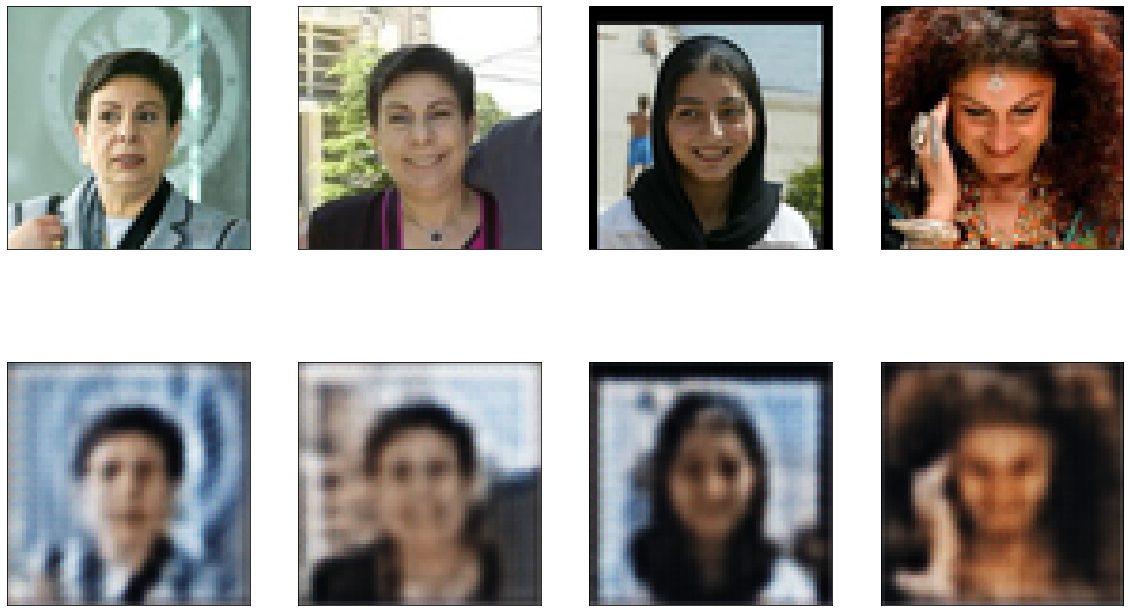

Running epoch 2/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:58 - loss: 0.0111 - acc: 0.674 - ETA: 2:55 - loss: 0.0117 - acc: 0.681 - ETA: 2:51 - loss: 0.0114 - acc: 0.687 - ETA: 2:48 - loss: 0.0114 - acc: 0.686 - ETA: 2:42 - loss: 0.0112 - acc: 0.687 - ETA: 2:38 - loss: 0.0111 - acc: 0.691 - ETA: 2:32 - loss: 0.0110 - acc: 0.692 - ETA: 2:27 - loss: 0.0109 - acc: 0.696 - ETA: 2:22 - loss: 0.0109 - acc: 0.696 - ETA: 2:17 - loss: 0.0108 - acc: 0.698 - ETA: 2:11 - loss: 0.0108 - acc: 0.700 - ETA: 2:06 - loss: 0.0109 - acc: 0.696 - ETA: 2:01 - loss: 0.0109 - acc: 0.697 - ETA: 1:56 - loss: 0.0109 - acc: 0.693 - ETA: 1:51 - loss: 0.0110 - acc: 0.693 - ETA: 1:46 - loss: 0.0109 - acc: 0.691 - ETA: 1:41 - loss: 0.0109 - acc: 0.692 - ETA: 1:36 - loss: 0.0108 - acc: 0.691 - ETA: 1:31 - loss: 0.0108 - acc: 0.693 - ETA: 1:27 - loss: 0.0107 - acc: 0.694 - ETA: 1:22 - loss: 0.0107 - acc: 0.694 - ETA: 1:17 - loss: 0.0106 - acc: 0.694 - ETA: 1:13 - loss: 0.0106 - acc: 0.694 - ETA: 1

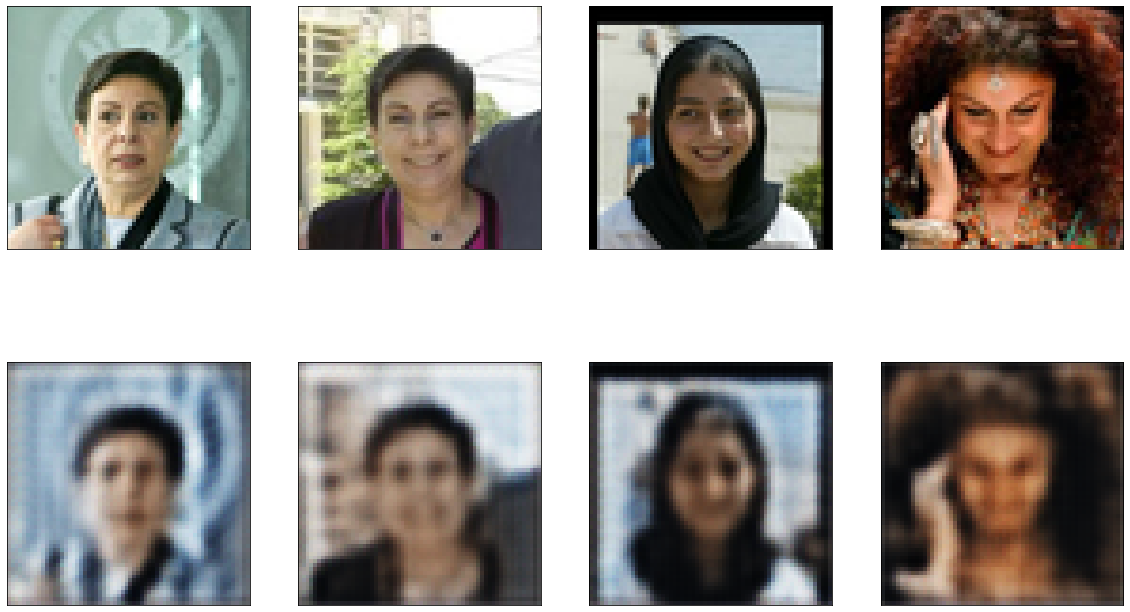

Running epoch 3/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:14 - loss: 0.0105 - acc: 0.706 - ETA: 2:59 - loss: 0.0102 - acc: 0.706 - ETA: 2:47 - loss: 0.0101 - acc: 0.702 - ETA: 2:39 - loss: 0.0101 - acc: 0.703 - ETA: 2:38 - loss: 0.0102 - acc: 0.704 - ETA: 2:32 - loss: 0.0102 - acc: 0.706 - ETA: 2:25 - loss: 0.0102 - acc: 0.708 - ETA: 2:24 - loss: 0.0103 - acc: 0.709 - ETA: 2:19 - loss: 0.0104 - acc: 0.709 - ETA: 2:14 - loss: 0.0104 - acc: 0.705 - ETA: 2:09 - loss: 0.0105 - acc: 0.706 - ETA: 2:04 - loss: 0.0105 - acc: 0.704 - ETA: 2:00 - loss: 0.0105 - acc: 0.704 - ETA: 1:55 - loss: 0.0105 - acc: 0.705 - ETA: 1:50 - loss: 0.0105 - acc: 0.704 - ETA: 1:45 - loss: 0.0105 - acc: 0.704 - ETA: 1:40 - loss: 0.0105 - acc: 0.704 - ETA: 1:36 - loss: 0.0105 - acc: 0.703 - ETA: 1:31 - loss: 0.0105 - acc: 0.705 - ETA: 1:26 - loss: 0.0105 - acc: 0.707 - ETA: 1:21 - loss: 0.0105 - acc: 0.706 - ETA: 1:17 - loss: 0.0106 - acc: 0.706 - ETA: 1:12 - loss: 0.0106 - acc: 0.707 - ETA: 1

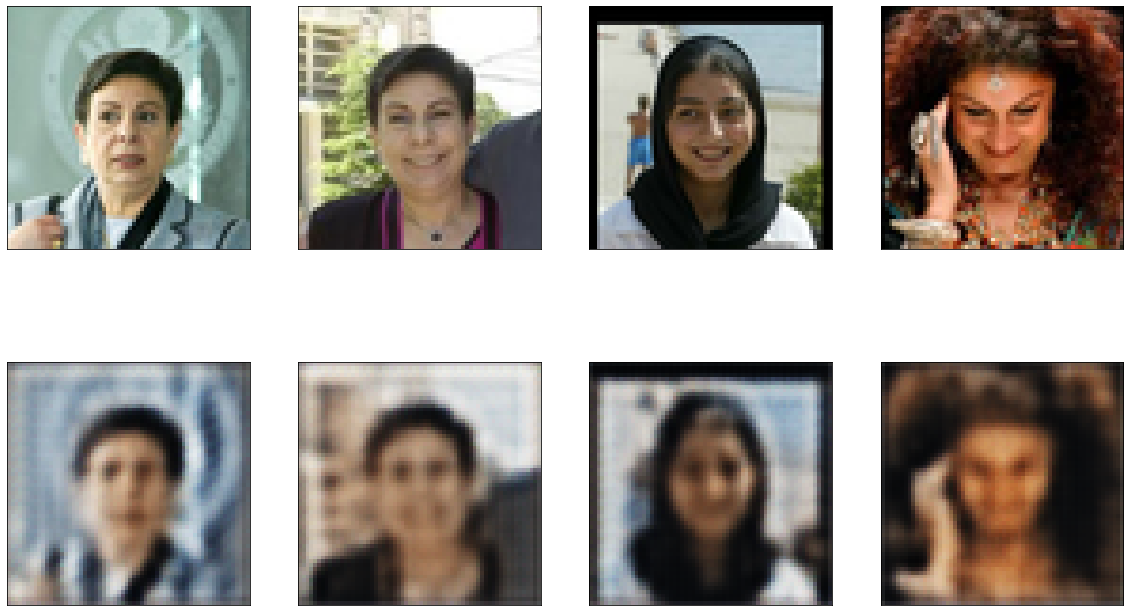

Running epoch 4/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:42 - loss: 0.0105 - acc: 0.683 - ETA: 2:35 - loss: 0.0109 - acc: 0.698 - ETA: 2:28 - loss: 0.0109 - acc: 0.701 - ETA: 2:24 - loss: 0.0110 - acc: 0.701 - ETA: 2:20 - loss: 0.0110 - acc: 0.693 - ETA: 2:15 - loss: 0.0111 - acc: 0.689 - ETA: 2:11 - loss: 0.0110 - acc: 0.688 - ETA: 2:08 - loss: 0.0110 - acc: 0.689 - ETA: 2:05 - loss: 0.0111 - acc: 0.689 - ETA: 2:00 - loss: 0.0111 - acc: 0.692 - ETA: 1:56 - loss: 0.0111 - acc: 0.693 - ETA: 1:52 - loss: 0.0110 - acc: 0.693 - ETA: 1:47 - loss: 0.0110 - acc: 0.694 - ETA: 1:43 - loss: 0.0110 - acc: 0.695 - ETA: 1:39 - loss: 0.0109 - acc: 0.695 - ETA: 1:35 - loss: 0.0109 - acc: 0.697 - ETA: 1:31 - loss: 0.0109 - acc: 0.698 - ETA: 1:26 - loss: 0.0108 - acc: 0.698 - ETA: 1:22 - loss: 0.0108 - acc: 0.700 - ETA: 1:18 - loss: 0.0108 - acc: 0.701 - ETA: 1:14 - loss: 0.0108 - acc: 0.702 - ETA: 1:10 - loss: 0.0108 - acc: 0.701 - ETA: 1:06 - loss: 0.0107 - acc: 0.701 - ETA: 1

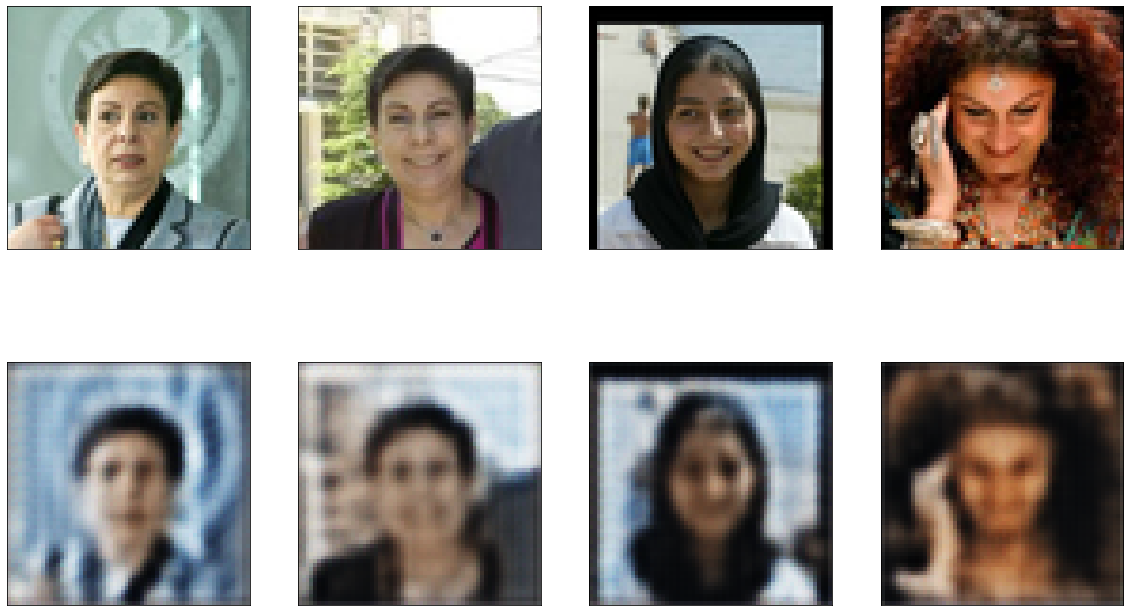

Running epoch 5/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:39 - loss: 0.0101 - acc: 0.689 - ETA: 2:35 - loss: 0.0104 - acc: 0.684 - ETA: 2:31 - loss: 0.0105 - acc: 0.681 - ETA: 2:25 - loss: 0.0106 - acc: 0.684 - ETA: 2:21 - loss: 0.0106 - acc: 0.679 - ETA: 2:18 - loss: 0.0105 - acc: 0.682 - ETA: 2:15 - loss: 0.0104 - acc: 0.684 - ETA: 2:12 - loss: 0.0103 - acc: 0.688 - ETA: 2:09 - loss: 0.0102 - acc: 0.691 - ETA: 2:05 - loss: 0.0101 - acc: 0.694 - ETA: 2:01 - loss: 0.0100 - acc: 0.698 - ETA: 1:56 - loss: 0.0101 - acc: 0.699 - ETA: 1:51 - loss: 0.0101 - acc: 0.700 - ETA: 1:47 - loss: 0.0101 - acc: 0.700 - ETA: 1:42 - loss: 0.0101 - acc: 0.700 - ETA: 1:38 - loss: 0.0101 - acc: 0.699 - ETA: 1:33 - loss: 0.0101 - acc: 0.699 - ETA: 1:29 - loss: 0.0101 - acc: 0.699 - ETA: 1:25 - loss: 0.0101 - acc: 0.699 - ETA: 1:20 - loss: 0.0101 - acc: 0.698 - ETA: 1:16 - loss: 0.0101 - acc: 0.699 - ETA: 1:12 - loss: 0.0101 - acc: 0.701 - ETA: 1:07 - loss: 0.0102 - acc: 0.701 - ETA: 1

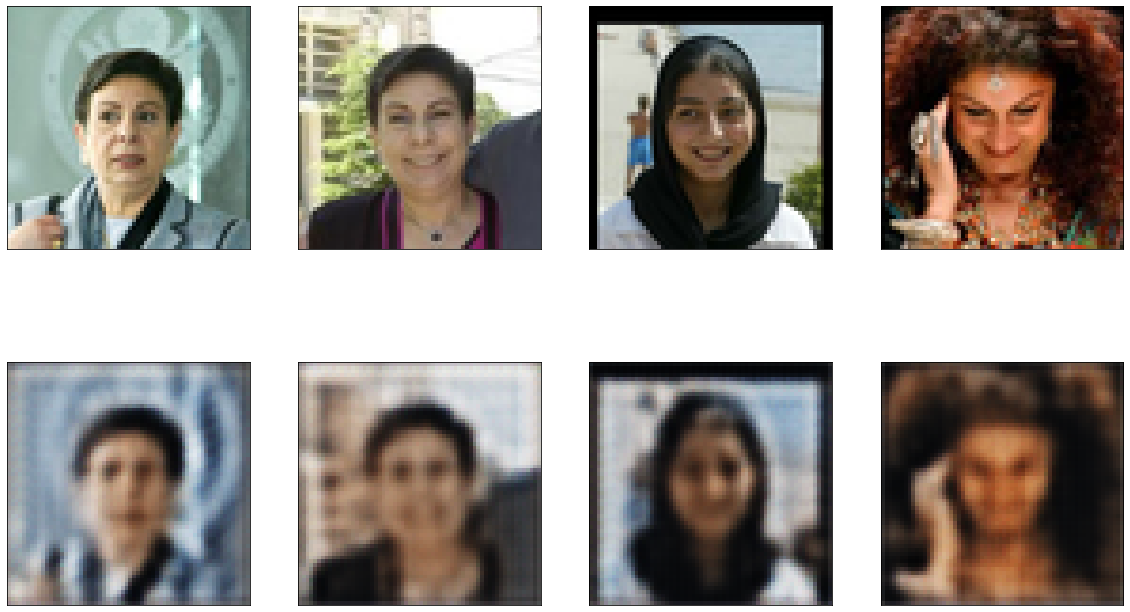

Running epoch 6/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:44 - loss: 0.0117 - acc: 0.726 - ETA: 2:38 - loss: 0.0115 - acc: 0.715 - ETA: 2:31 - loss: 0.0111 - acc: 0.711 - ETA: 2:27 - loss: 0.0108 - acc: 0.709 - ETA: 2:22 - loss: 0.0107 - acc: 0.713 - ETA: 2:17 - loss: 0.0106 - acc: 0.709 - ETA: 2:13 - loss: 0.0107 - acc: 0.710 - ETA: 2:09 - loss: 0.0108 - acc: 0.708 - ETA: 2:05 - loss: 0.0107 - acc: 0.707 - ETA: 2:00 - loss: 0.0107 - acc: 0.701 - ETA: 1:56 - loss: 0.0106 - acc: 0.704 - ETA: 1:52 - loss: 0.0105 - acc: 0.702 - ETA: 1:47 - loss: 0.0105 - acc: 0.702 - ETA: 1:43 - loss: 0.0104 - acc: 0.700 - ETA: 1:39 - loss: 0.0104 - acc: 0.700 - ETA: 1:35 - loss: 0.0104 - acc: 0.699 - ETA: 1:31 - loss: 0.0104 - acc: 0.698 - ETA: 1:27 - loss: 0.0104 - acc: 0.697 - ETA: 1:23 - loss: 0.0103 - acc: 0.698 - ETA: 1:19 - loss: 0.0103 - acc: 0.698 - ETA: 1:15 - loss: 0.0102 - acc: 0.698 - ETA: 1:11 - loss: 0.0102 - acc: 0.697 - ETA: 1:06 - loss: 0.0101 - acc: 0.696 - ETA: 1

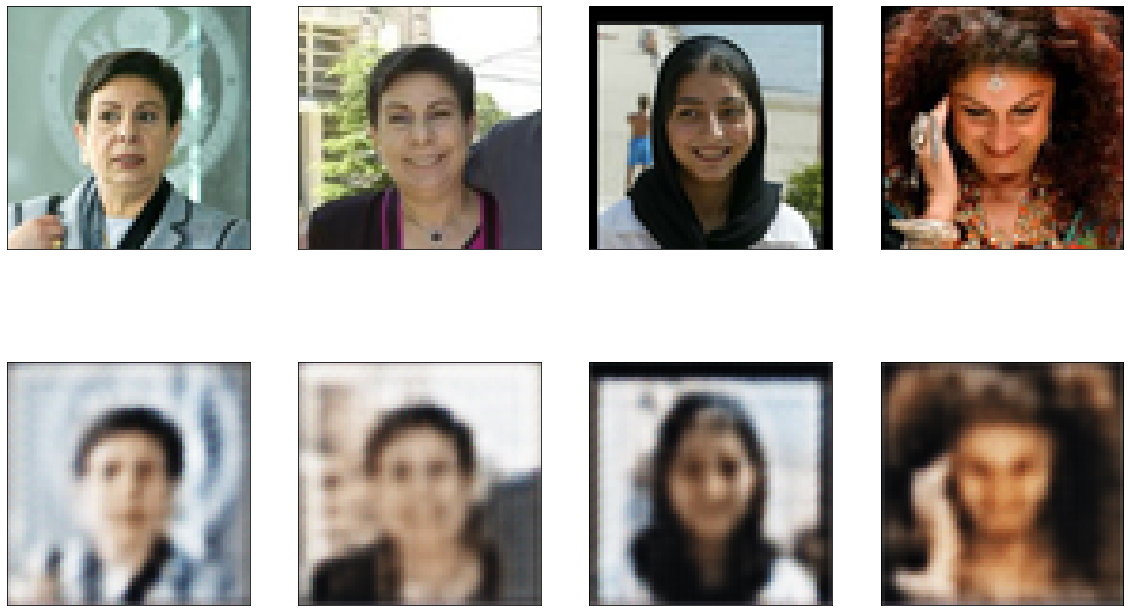

Running epoch 7/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:05 - loss: 0.0133 - acc: 0.742 - ETA: 2:53 - loss: 0.0134 - acc: 0.725 - ETA: 2:45 - loss: 0.0128 - acc: 0.720 - ETA: 2:38 - loss: 0.0126 - acc: 0.717 - ETA: 2:32 - loss: 0.0122 - acc: 0.721 - ETA: 2:26 - loss: 0.0119 - acc: 0.721 - ETA: 2:21 - loss: 0.0117 - acc: 0.722 - ETA: 2:15 - loss: 0.0115 - acc: 0.719 - ETA: 2:10 - loss: 0.0114 - acc: 0.720 - ETA: 2:05 - loss: 0.0112 - acc: 0.720 - ETA: 2:01 - loss: 0.0111 - acc: 0.719 - ETA: 1:56 - loss: 0.0110 - acc: 0.720 - ETA: 1:52 - loss: 0.0109 - acc: 0.719 - ETA: 1:47 - loss: 0.0108 - acc: 0.716 - ETA: 1:43 - loss: 0.0108 - acc: 0.717 - ETA: 1:38 - loss: 0.0108 - acc: 0.715 - ETA: 1:34 - loss: 0.0108 - acc: 0.714 - ETA: 1:30 - loss: 0.0108 - acc: 0.713 - ETA: 1:25 - loss: 0.0108 - acc: 0.712 - ETA: 1:21 - loss: 0.0108 - acc: 0.711 - ETA: 1:17 - loss: 0.0107 - acc: 0.711 - ETA: 1:12 - loss: 0.0107 - acc: 0.710 - ETA: 1:08 - loss: 0.0106 - acc: 0.710 - ETA: 1

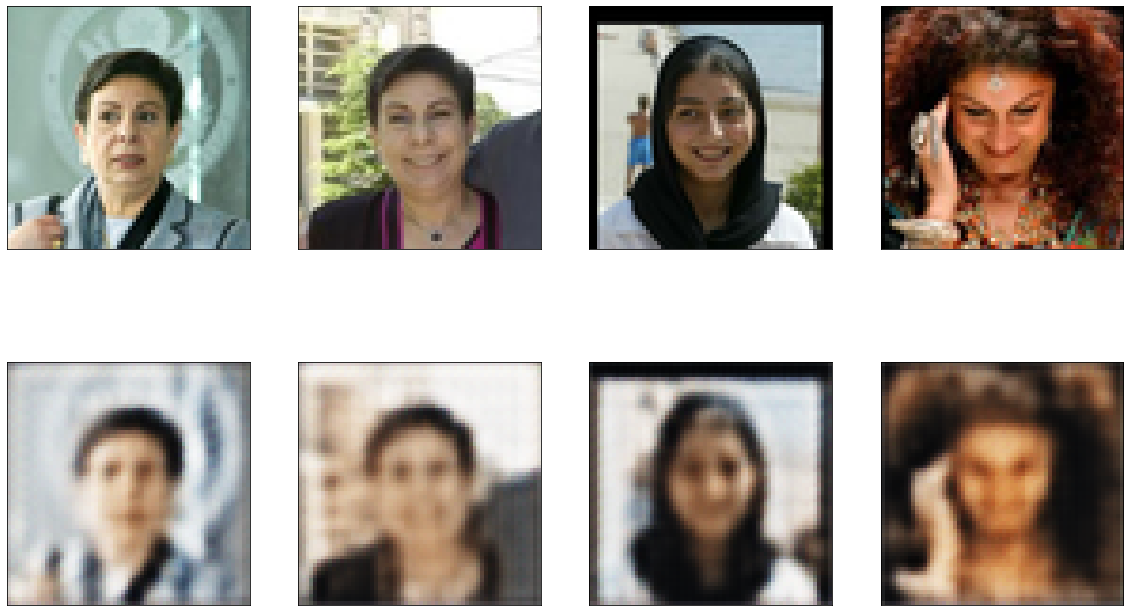

Running epoch 8/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:44 - loss: 0.0139 - acc: 0.712 - ETA: 2:38 - loss: 0.0135 - acc: 0.714 - ETA: 2:34 - loss: 0.0126 - acc: 0.719 - ETA: 2:29 - loss: 0.0122 - acc: 0.709 - ETA: 2:24 - loss: 0.0119 - acc: 0.705 - ETA: 2:19 - loss: 0.0116 - acc: 0.707 - ETA: 2:15 - loss: 0.0114 - acc: 0.709 - ETA: 2:10 - loss: 0.0113 - acc: 0.711 - ETA: 2:06 - loss: 0.0112 - acc: 0.713 - ETA: 2:03 - loss: 0.0111 - acc: 0.712 - ETA: 1:59 - loss: 0.0111 - acc: 0.712 - ETA: 1:55 - loss: 0.0110 - acc: 0.713 - ETA: 1:51 - loss: 0.0109 - acc: 0.714 - ETA: 1:46 - loss: 0.0109 - acc: 0.714 - ETA: 1:42 - loss: 0.0108 - acc: 0.714 - ETA: 1:37 - loss: 0.0107 - acc: 0.715 - ETA: 1:33 - loss: 0.0107 - acc: 0.716 - ETA: 1:29 - loss: 0.0106 - acc: 0.715 - ETA: 1:24 - loss: 0.0106 - acc: 0.716 - ETA: 1:20 - loss: 0.0105 - acc: 0.716 - ETA: 1:16 - loss: 0.0105 - acc: 0.716 - ETA: 1:12 - loss: 0.0105 - acc: 0.717 - ETA: 1:08 - loss: 0.0104 - acc: 0.716 - ETA: 1

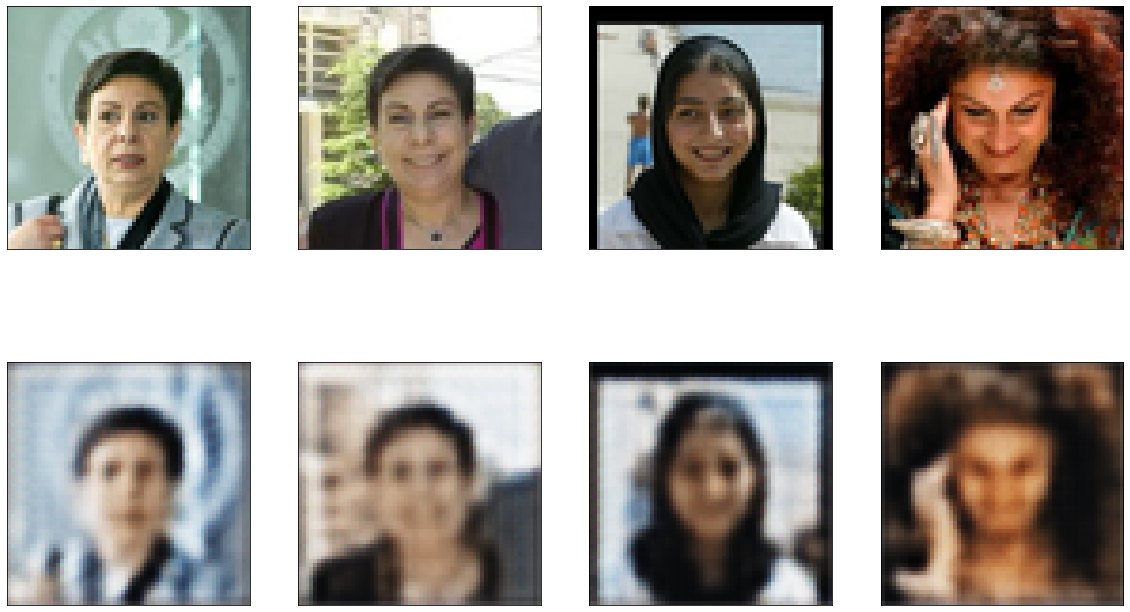

Running epoch 9/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:53 - loss: 0.0094 - acc: 0.718 - ETA: 3:43 - loss: 0.0095 - acc: 0.718 - ETA: 3:39 - loss: 0.0096 - acc: 0.726 - ETA: 3:31 - loss: 0.0096 - acc: 0.726 - ETA: 3:24 - loss: 0.0097 - acc: 0.717 - ETA: 3:18 - loss: 0.0097 - acc: 0.717 - ETA: 3:11 - loss: 0.0098 - acc: 0.712 - ETA: 3:05 - loss: 0.0097 - acc: 0.709 - ETA: 2:59 - loss: 0.0097 - acc: 0.707 - ETA: 2:53 - loss: 0.0097 - acc: 0.706 - ETA: 2:47 - loss: 0.0097 - acc: 0.698 - ETA: 2:41 - loss: 0.0098 - acc: 0.699 - ETA: 2:34 - loss: 0.0098 - acc: 0.694 - ETA: 2:29 - loss: 0.0098 - acc: 0.694 - ETA: 2:23 - loss: 0.0098 - acc: 0.690 - ETA: 2:17 - loss: 0.0098 - acc: 0.690 - ETA: 2:11 - loss: 0.0098 - acc: 0.688 - ETA: 2:05 - loss: 0.0098 - acc: 0.690 - ETA: 1:59 - loss: 0.0097 - acc: 0.691 - ETA: 1:53 - loss: 0.0097 - acc: 0.692 - ETA: 1:47 - loss: 0.0098 - acc: 0.692 - ETA: 1:41 - loss: 0.0098 - acc: 0.693 - ETA: 1:35 - loss: 0.0097 - acc: 0.694 - ETA: 1

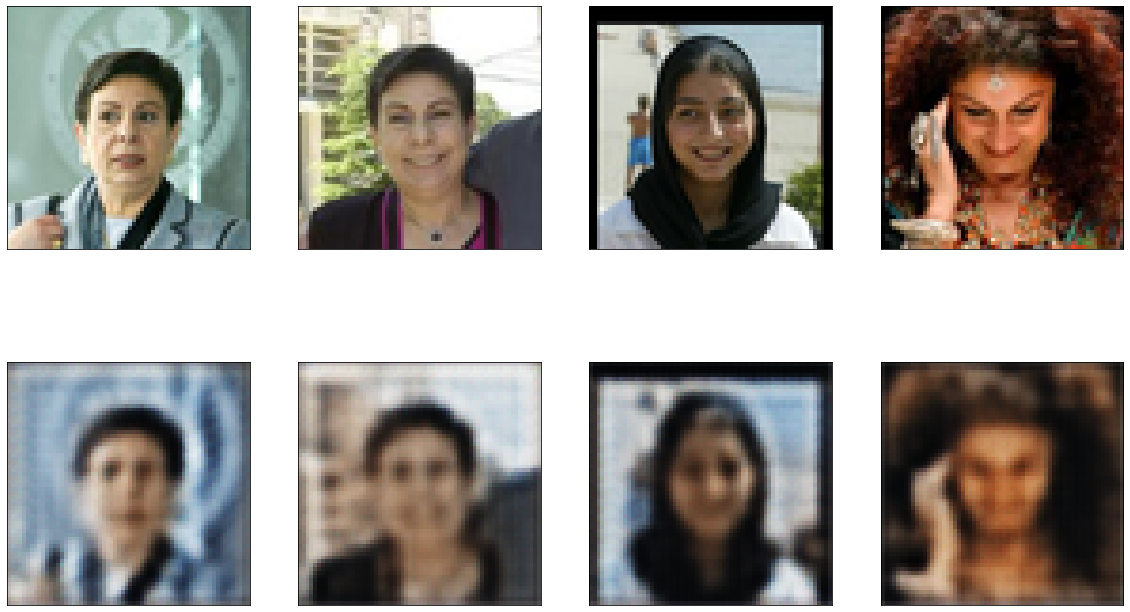

Running epoch 10/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:53 - loss: 0.0104 - acc: 0.729 - ETA: 3:45 - loss: 0.0106 - acc: 0.731 - ETA: 3:36 - loss: 0.0109 - acc: 0.729 - ETA: 3:29 - loss: 0.0110 - acc: 0.724 - ETA: 3:25 - loss: 0.0109 - acc: 0.724 - ETA: 3:18 - loss: 0.0108 - acc: 0.725 - ETA: 3:12 - loss: 0.0108 - acc: 0.724 - ETA: 3:06 - loss: 0.0108 - acc: 0.725 - ETA: 2:59 - loss: 0.0108 - acc: 0.726 - ETA: 2:53 - loss: 0.0108 - acc: 0.725 - ETA: 2:47 - loss: 0.0108 - acc: 0.725 - ETA: 2:41 - loss: 0.0108 - acc: 0.725 - ETA: 2:35 - loss: 0.0107 - acc: 0.724 - ETA: 2:29 - loss: 0.0107 - acc: 0.724 - ETA: 2:23 - loss: 0.0107 - acc: 0.724 - ETA: 2:17 - loss: 0.0106 - acc: 0.723 - ETA: 2:11 - loss: 0.0106 - acc: 0.723 - ETA: 2:05 - loss: 0.0105 - acc: 0.724 - ETA: 1:59 - loss: 0.0105 - acc: 0.723 - ETA: 1:53 - loss: 0.0104 - acc: 0.723 - ETA: 1:47 - loss: 0.0104 - acc: 0.724 - ETA: 1:41 - loss: 0.0104 - acc: 0.722 - ETA: 1:35 - loss: 0.0104 - acc: 0.722 - ETA: 

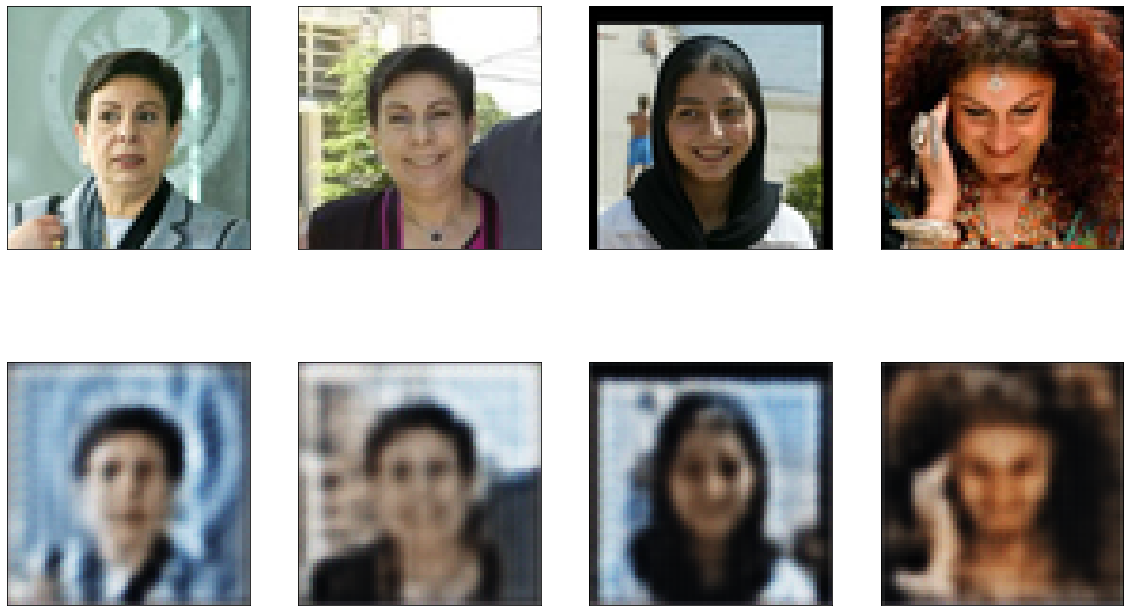

Running epoch 11/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:46 - loss: 0.0104 - acc: 0.675 - ETA: 3:41 - loss: 0.0107 - acc: 0.681 - ETA: 3:40 - loss: 0.0104 - acc: 0.682 - ETA: 3:32 - loss: 0.0106 - acc: 0.683 - ETA: 3:24 - loss: 0.0102 - acc: 0.685 - ETA: 3:17 - loss: 0.0101 - acc: 0.692 - ETA: 3:10 - loss: 0.0099 - acc: 0.696 - ETA: 3:03 - loss: 0.0098 - acc: 0.700 - ETA: 2:56 - loss: 0.0098 - acc: 0.704 - ETA: 2:50 - loss: 0.0097 - acc: 0.704 - ETA: 2:44 - loss: 0.0096 - acc: 0.709 - ETA: 2:38 - loss: 0.0096 - acc: 0.710 - ETA: 2:31 - loss: 0.0097 - acc: 0.711 - ETA: 2:25 - loss: 0.0097 - acc: 0.710 - ETA: 2:19 - loss: 0.0098 - acc: 0.711 - ETA: 2:13 - loss: 0.0098 - acc: 0.711 - ETA: 2:07 - loss: 0.0098 - acc: 0.710 - ETA: 2:01 - loss: 0.0098 - acc: 0.710 - ETA: 1:55 - loss: 0.0098 - acc: 0.711 - ETA: 1:49 - loss: 0.0098 - acc: 0.712 - ETA: 1:44 - loss: 0.0098 - acc: 0.712 - ETA: 1:38 - loss: 0.0099 - acc: 0.713 - ETA: 1:32 - loss: 0.0099 - acc: 0.713 - ETA: 

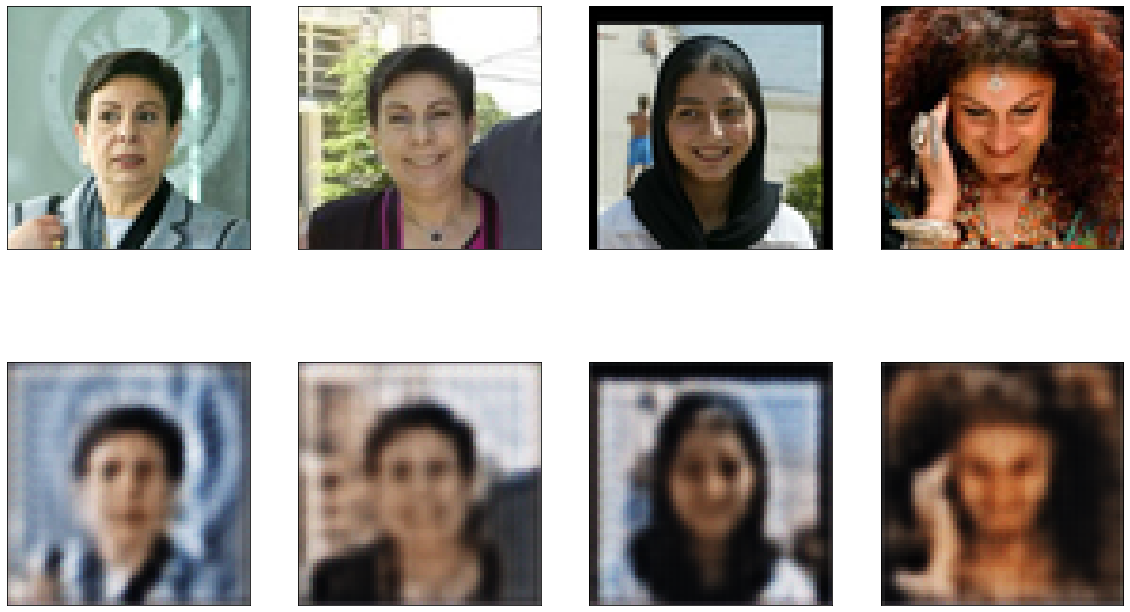

Running epoch 12/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:35 - loss: 0.0106 - acc: 0.713 - ETA: 3:27 - loss: 0.0106 - acc: 0.716 - ETA: 3:22 - loss: 0.0105 - acc: 0.715 - ETA: 3:19 - loss: 0.0105 - acc: 0.716 - ETA: 3:13 - loss: 0.0104 - acc: 0.709 - ETA: 3:08 - loss: 0.0105 - acc: 0.712 - ETA: 3:03 - loss: 0.0104 - acc: 0.713 - ETA: 2:57 - loss: 0.0104 - acc: 0.714 - ETA: 2:52 - loss: 0.0103 - acc: 0.711 - ETA: 2:46 - loss: 0.0103 - acc: 0.711 - ETA: 2:40 - loss: 0.0102 - acc: 0.710 - ETA: 2:34 - loss: 0.0101 - acc: 0.710 - ETA: 2:28 - loss: 0.0101 - acc: 0.710 - ETA: 2:22 - loss: 0.0100 - acc: 0.709 - ETA: 2:18 - loss: 0.0099 - acc: 0.710 - ETA: 2:12 - loss: 0.0098 - acc: 0.711 - ETA: 2:06 - loss: 0.0098 - acc: 0.711 - ETA: 2:00 - loss: 0.0097 - acc: 0.713 - ETA: 1:54 - loss: 0.0097 - acc: 0.713 - ETA: 1:49 - loss: 0.0097 - acc: 0.712 - ETA: 1:43 - loss: 0.0097 - acc: 0.711 - ETA: 1:37 - loss: 0.0097 - acc: 0.712 - ETA: 1:31 - loss: 0.0096 - acc: 0.713 - ETA: 

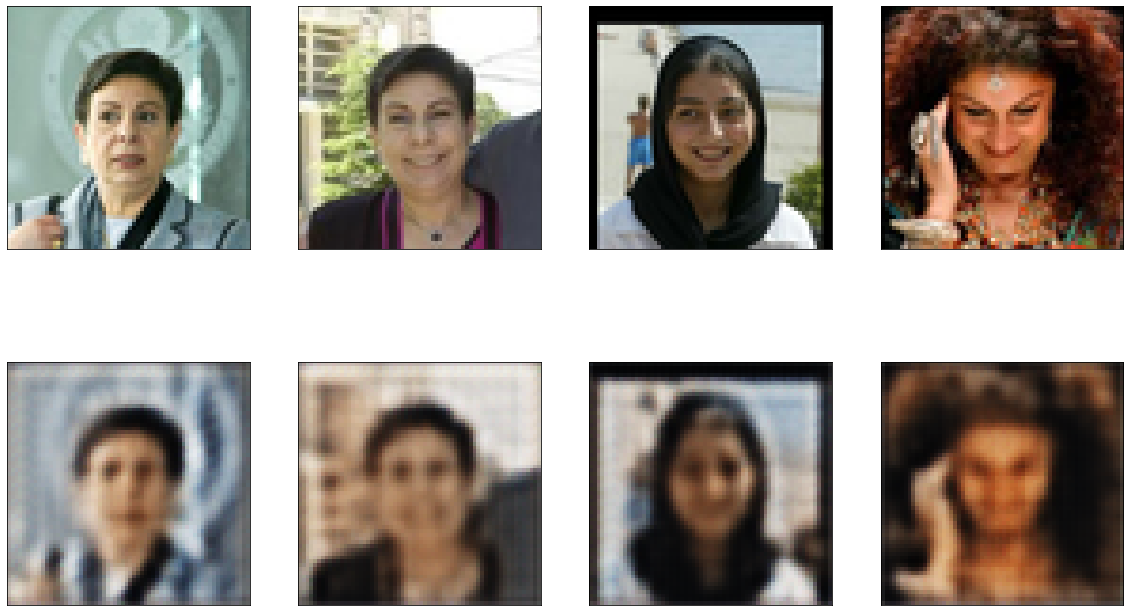

Running epoch 13/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:42 - loss: 0.0108 - acc: 0.726 - ETA: 3:32 - loss: 0.0107 - acc: 0.719 - ETA: 3:27 - loss: 0.0109 - acc: 0.722 - ETA: 3:20 - loss: 0.0109 - acc: 0.718 - ETA: 3:15 - loss: 0.0109 - acc: 0.718 - ETA: 3:09 - loss: 0.0109 - acc: 0.718 - ETA: 3:05 - loss: 0.0108 - acc: 0.719 - ETA: 3:01 - loss: 0.0107 - acc: 0.719 - ETA: 2:56 - loss: 0.0106 - acc: 0.720 - ETA: 2:50 - loss: 0.0106 - acc: 0.718 - ETA: 2:44 - loss: 0.0105 - acc: 0.716 - ETA: 2:38 - loss: 0.0106 - acc: 0.715 - ETA: 2:32 - loss: 0.0106 - acc: 0.711 - ETA: 2:26 - loss: 0.0106 - acc: 0.710 - ETA: 2:20 - loss: 0.0106 - acc: 0.710 - ETA: 2:14 - loss: 0.0106 - acc: 0.711 - ETA: 2:08 - loss: 0.0105 - acc: 0.709 - ETA: 2:03 - loss: 0.0105 - acc: 0.708 - ETA: 1:57 - loss: 0.0104 - acc: 0.709 - ETA: 1:51 - loss: 0.0103 - acc: 0.709 - ETA: 1:45 - loss: 0.0103 - acc: 0.709 - ETA: 1:39 - loss: 0.0102 - acc: 0.709 - ETA: 1:33 - loss: 0.0102 - acc: 0.709 - ETA: 

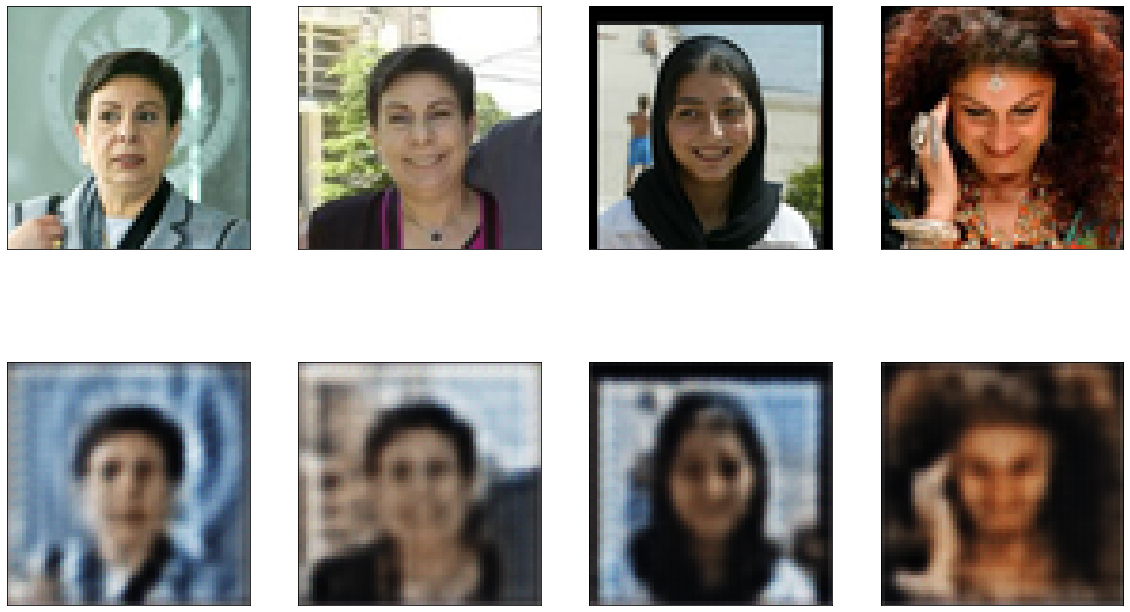

Running epoch 14/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:45 - loss: 0.0144 - acc: 0.681 - ETA: 3:35 - loss: 0.0137 - acc: 0.688 - ETA: 3:28 - loss: 0.0126 - acc: 0.701 - ETA: 3:20 - loss: 0.0118 - acc: 0.711 - ETA: 3:13 - loss: 0.0114 - acc: 0.712 - ETA: 3:08 - loss: 0.0111 - acc: 0.710 - ETA: 3:02 - loss: 0.0110 - acc: 0.713 - ETA: 2:56 - loss: 0.0108 - acc: 0.710 - ETA: 2:50 - loss: 0.0108 - acc: 0.711 - ETA: 2:44 - loss: 0.0107 - acc: 0.709 - ETA: 2:39 - loss: 0.0107 - acc: 0.711 - ETA: 2:33 - loss: 0.0106 - acc: 0.711 - ETA: 2:27 - loss: 0.0104 - acc: 0.714 - ETA: 2:22 - loss: 0.0103 - acc: 0.714 - ETA: 2:16 - loss: 0.0102 - acc: 0.715 - ETA: 2:09 - loss: 0.0101 - acc: 0.717 - ETA: 2:02 - loss: 0.0100 - acc: 0.717 - ETA: 1:56 - loss: 0.0100 - acc: 0.717 - ETA: 1:49 - loss: 0.0100 - acc: 0.718 - ETA: 1:43 - loss: 0.0099 - acc: 0.718 - ETA: 1:37 - loss: 0.0099 - acc: 0.719 - ETA: 1:31 - loss: 0.0099 - acc: 0.718 - ETA: 1:24 - loss: 0.0099 - acc: 0.717 - ETA: 

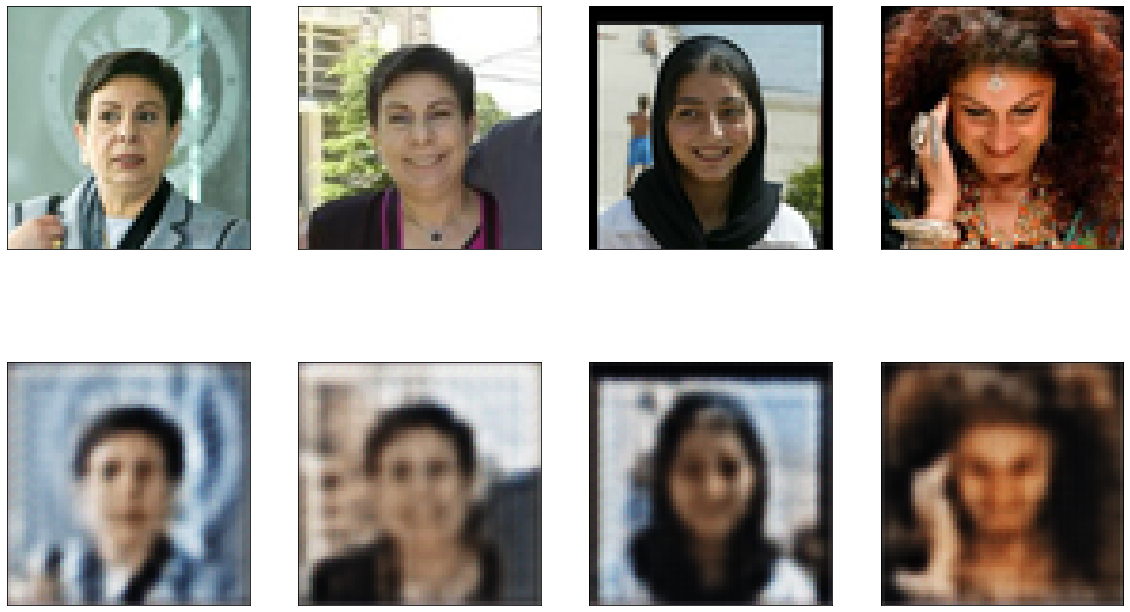

Running epoch 15/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:42 - loss: 0.0090 - acc: 0.727 - ETA: 2:36 - loss: 0.0092 - acc: 0.729 - ETA: 2:30 - loss: 0.0092 - acc: 0.730 - ETA: 2:25 - loss: 0.0092 - acc: 0.731 - ETA: 2:20 - loss: 0.0094 - acc: 0.728 - ETA: 2:16 - loss: 0.0095 - acc: 0.731 - ETA: 2:13 - loss: 0.0097 - acc: 0.731 - ETA: 2:09 - loss: 0.0099 - acc: 0.732 - ETA: 2:04 - loss: 0.0100 - acc: 0.733 - ETA: 2:00 - loss: 0.0101 - acc: 0.733 - ETA: 1:56 - loss: 0.0102 - acc: 0.732 - ETA: 1:52 - loss: 0.0101 - acc: 0.730 - ETA: 1:48 - loss: 0.0102 - acc: 0.732 - ETA: 1:43 - loss: 0.0101 - acc: 0.732 - ETA: 1:39 - loss: 0.0101 - acc: 0.731 - ETA: 1:36 - loss: 0.0100 - acc: 0.731 - ETA: 1:32 - loss: 0.0100 - acc: 0.731 - ETA: 1:28 - loss: 0.0100 - acc: 0.731 - ETA: 1:24 - loss: 0.0099 - acc: 0.730 - ETA: 1:20 - loss: 0.0099 - acc: 0.731 - ETA: 1:15 - loss: 0.0098 - acc: 0.728 - ETA: 1:11 - loss: 0.0099 - acc: 0.728 - ETA: 1:07 - loss: 0.0099 - acc: 0.726 - ETA: 

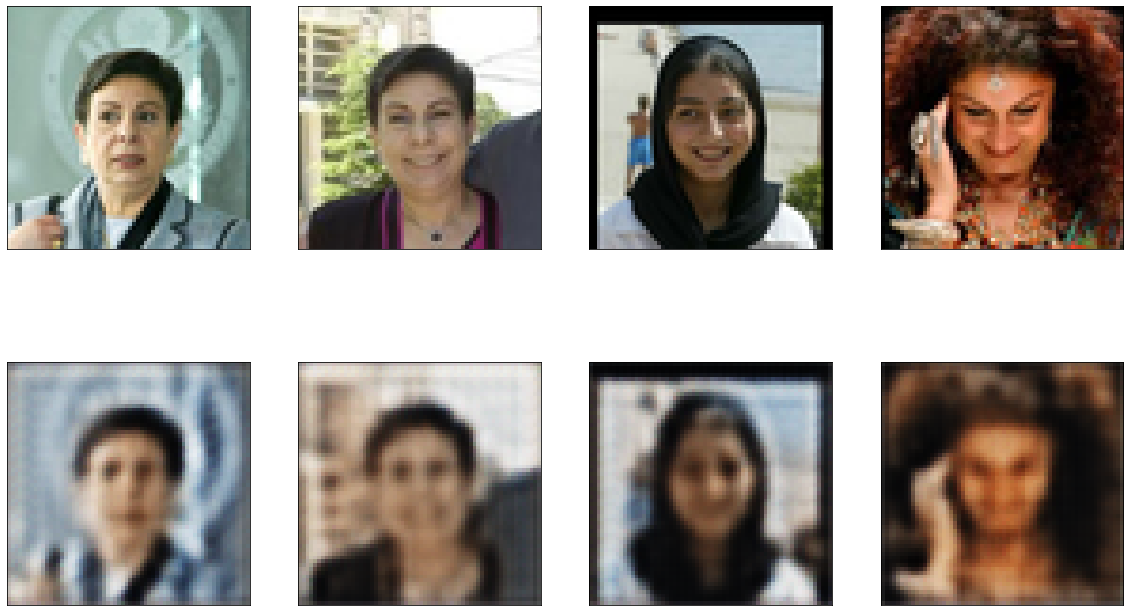

Running epoch 16/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:37 - loss: 0.0090 - acc: 0.751 - ETA: 2:31 - loss: 0.0089 - acc: 0.744 - ETA: 2:27 - loss: 0.0090 - acc: 0.739 - ETA: 2:23 - loss: 0.0091 - acc: 0.734 - ETA: 2:18 - loss: 0.0092 - acc: 0.738 - ETA: 2:14 - loss: 0.0093 - acc: 0.741 - ETA: 2:10 - loss: 0.0094 - acc: 0.740 - ETA: 2:06 - loss: 0.0094 - acc: 0.738 - ETA: 2:02 - loss: 0.0095 - acc: 0.739 - ETA: 1:58 - loss: 0.0097 - acc: 0.739 - ETA: 1:54 - loss: 0.0099 - acc: 0.738 - ETA: 1:51 - loss: 0.0099 - acc: 0.739 - ETA: 1:47 - loss: 0.0100 - acc: 0.740 - ETA: 1:43 - loss: 0.0101 - acc: 0.739 - ETA: 1:39 - loss: 0.0101 - acc: 0.739 - ETA: 1:35 - loss: 0.0101 - acc: 0.738 - ETA: 1:30 - loss: 0.0101 - acc: 0.738 - ETA: 1:27 - loss: 0.0101 - acc: 0.738 - ETA: 1:23 - loss: 0.0101 - acc: 0.737 - ETA: 1:19 - loss: 0.0101 - acc: 0.736 - ETA: 1:15 - loss: 0.0101 - acc: 0.736 - ETA: 1:11 - loss: 0.0101 - acc: 0.735 - ETA: 1:06 - loss: 0.0101 - acc: 0.734 - ETA: 

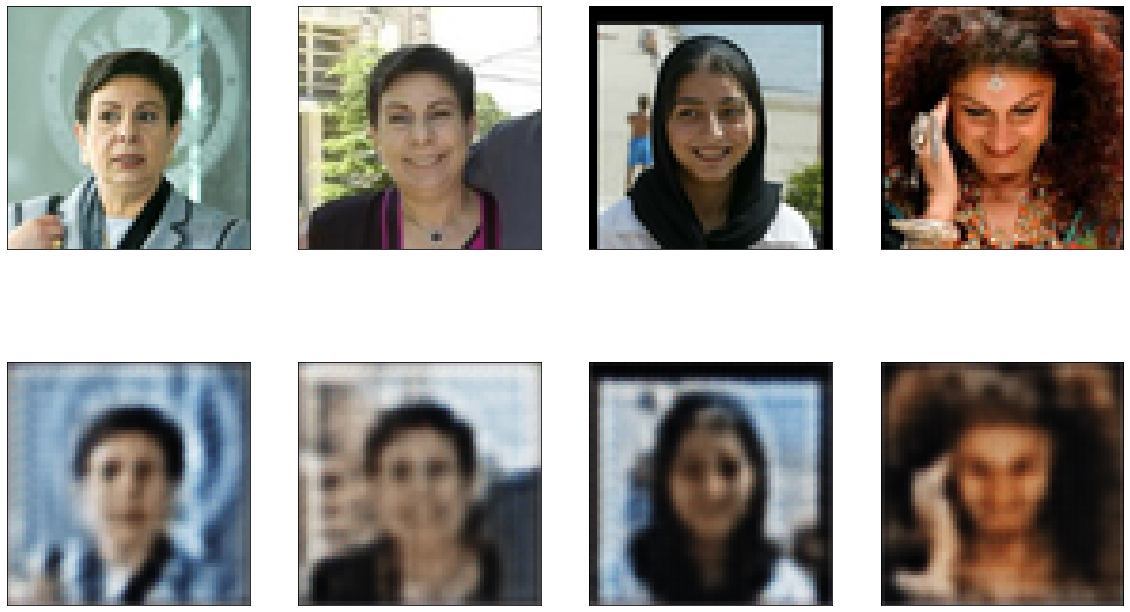

Running epoch 17/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:39 - loss: 0.0115 - acc: 0.694 - ETA: 2:35 - loss: 0.0115 - acc: 0.719 - ETA: 2:28 - loss: 0.0112 - acc: 0.721 - ETA: 2:25 - loss: 0.0109 - acc: 0.714 - ETA: 2:20 - loss: 0.0107 - acc: 0.714 - ETA: 2:15 - loss: 0.0106 - acc: 0.720 - ETA: 2:11 - loss: 0.0105 - acc: 0.720 - ETA: 2:07 - loss: 0.0103 - acc: 0.718 - ETA: 2:03 - loss: 0.0102 - acc: 0.721 - ETA: 1:59 - loss: 0.0102 - acc: 0.718 - ETA: 1:54 - loss: 0.0102 - acc: 0.718 - ETA: 1:50 - loss: 0.0102 - acc: 0.714 - ETA: 1:47 - loss: 0.0102 - acc: 0.714 - ETA: 1:43 - loss: 0.0102 - acc: 0.711 - ETA: 1:38 - loss: 0.0101 - acc: 0.712 - ETA: 1:34 - loss: 0.0100 - acc: 0.711 - ETA: 1:30 - loss: 0.0100 - acc: 0.711 - ETA: 1:26 - loss: 0.0099 - acc: 0.711 - ETA: 1:22 - loss: 0.0098 - acc: 0.711 - ETA: 1:18 - loss: 0.0097 - acc: 0.712 - ETA: 1:14 - loss: 0.0097 - acc: 0.712 - ETA: 1:09 - loss: 0.0096 - acc: 0.713 - ETA: 1:05 - loss: 0.0096 - acc: 0.714 - ETA: 

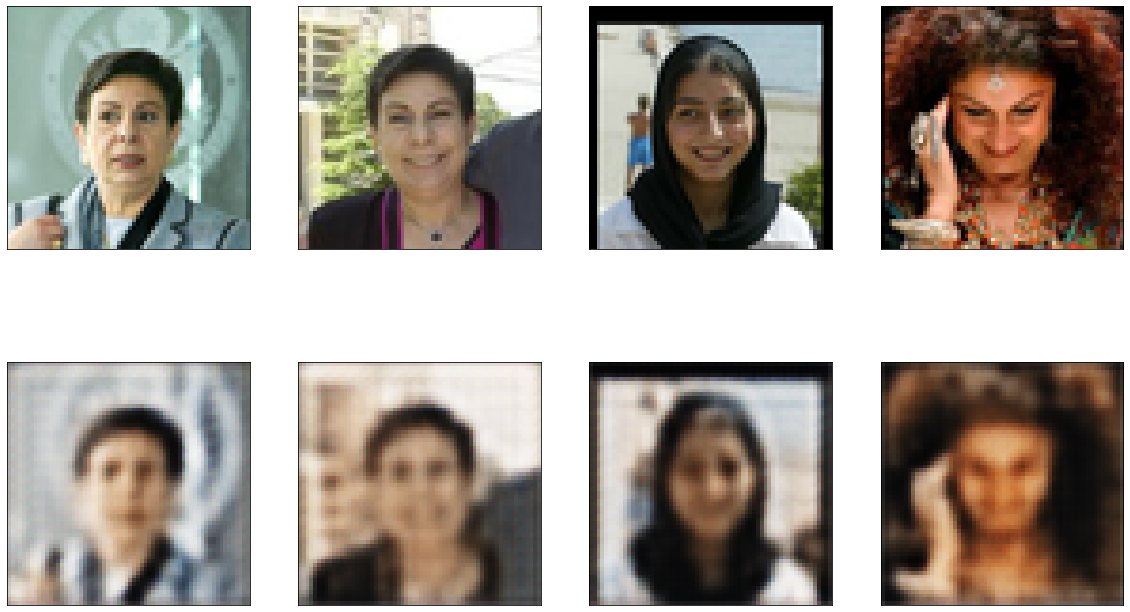

Running epoch 18/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:41 - loss: 0.0092 - acc: 0.697 - ETA: 2:33 - loss: 0.0089 - acc: 0.696 - ETA: 2:27 - loss: 0.0090 - acc: 0.710 - ETA: 2:23 - loss: 0.0090 - acc: 0.714 - ETA: 2:19 - loss: 0.0090 - acc: 0.719 - ETA: 2:15 - loss: 0.0090 - acc: 0.719 - ETA: 2:10 - loss: 0.0092 - acc: 0.723 - ETA: 2:06 - loss: 0.0092 - acc: 0.725 - ETA: 2:02 - loss: 0.0093 - acc: 0.726 - ETA: 1:59 - loss: 0.0094 - acc: 0.729 - ETA: 1:54 - loss: 0.0095 - acc: 0.731 - ETA: 1:50 - loss: 0.0096 - acc: 0.732 - ETA: 1:46 - loss: 0.0097 - acc: 0.733 - ETA: 1:42 - loss: 0.0098 - acc: 0.733 - ETA: 1:38 - loss: 0.0099 - acc: 0.734 - ETA: 1:34 - loss: 0.0100 - acc: 0.733 - ETA: 1:30 - loss: 0.0100 - acc: 0.734 - ETA: 1:25 - loss: 0.0101 - acc: 0.734 - ETA: 1:21 - loss: 0.0101 - acc: 0.734 - ETA: 1:17 - loss: 0.0101 - acc: 0.733 - ETA: 1:13 - loss: 0.0101 - acc: 0.733 - ETA: 1:09 - loss: 0.0101 - acc: 0.733 - ETA: 1:05 - loss: 0.0101 - acc: 0.733 - ETA: 

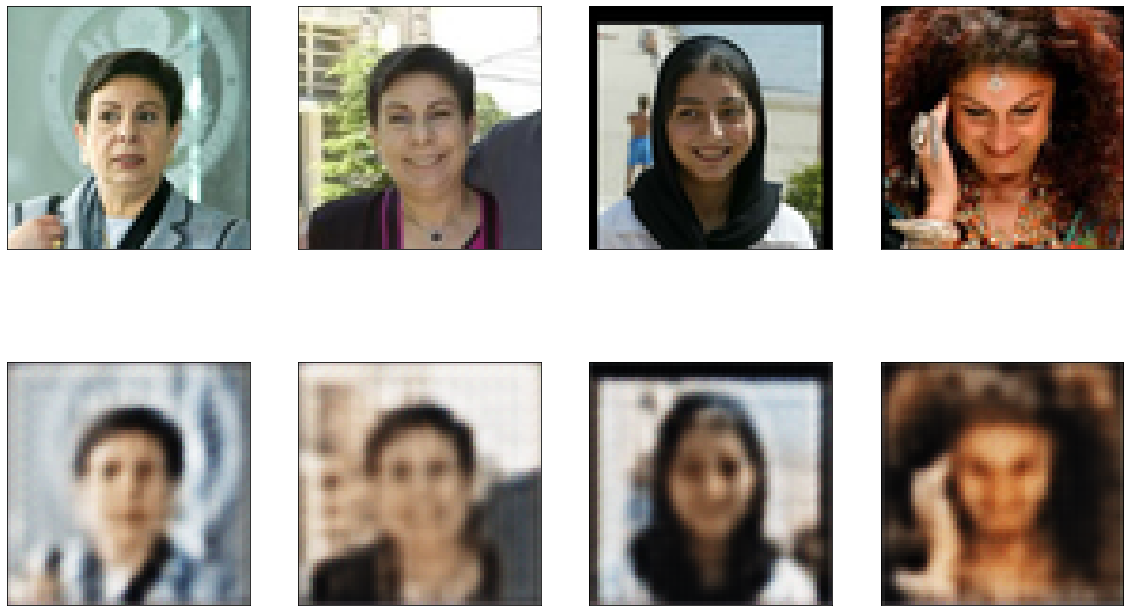

Running epoch 19/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:03 - loss: 0.0092 - acc: 0.722 - ETA: 2:42 - loss: 0.0094 - acc: 0.727 - ETA: 2:33 - loss: 0.0095 - acc: 0.724 - ETA: 2:25 - loss: 0.0095 - acc: 0.722 - ETA: 2:20 - loss: 0.0094 - acc: 0.725 - ETA: 2:16 - loss: 0.0094 - acc: 0.728 - ETA: 2:12 - loss: 0.0093 - acc: 0.730 - ETA: 2:07 - loss: 0.0093 - acc: 0.729 - ETA: 2:03 - loss: 0.0093 - acc: 0.731 - ETA: 1:59 - loss: 0.0093 - acc: 0.732 - ETA: 1:55 - loss: 0.0092 - acc: 0.732 - ETA: 1:51 - loss: 0.0092 - acc: 0.731 - ETA: 1:46 - loss: 0.0092 - acc: 0.730 - ETA: 1:42 - loss: 0.0092 - acc: 0.730 - ETA: 1:38 - loss: 0.0091 - acc: 0.731 - ETA: 1:34 - loss: 0.0092 - acc: 0.730 - ETA: 1:30 - loss: 0.0092 - acc: 0.730 - ETA: 1:26 - loss: 0.0092 - acc: 0.732 - ETA: 1:21 - loss: 0.0092 - acc: 0.731 - ETA: 1:17 - loss: 0.0092 - acc: 0.731 - ETA: 1:13 - loss: 0.0092 - acc: 0.731 - ETA: 1:09 - loss: 0.0093 - acc: 0.732 - ETA: 1:05 - loss: 0.0093 - acc: 0.732 - ETA: 

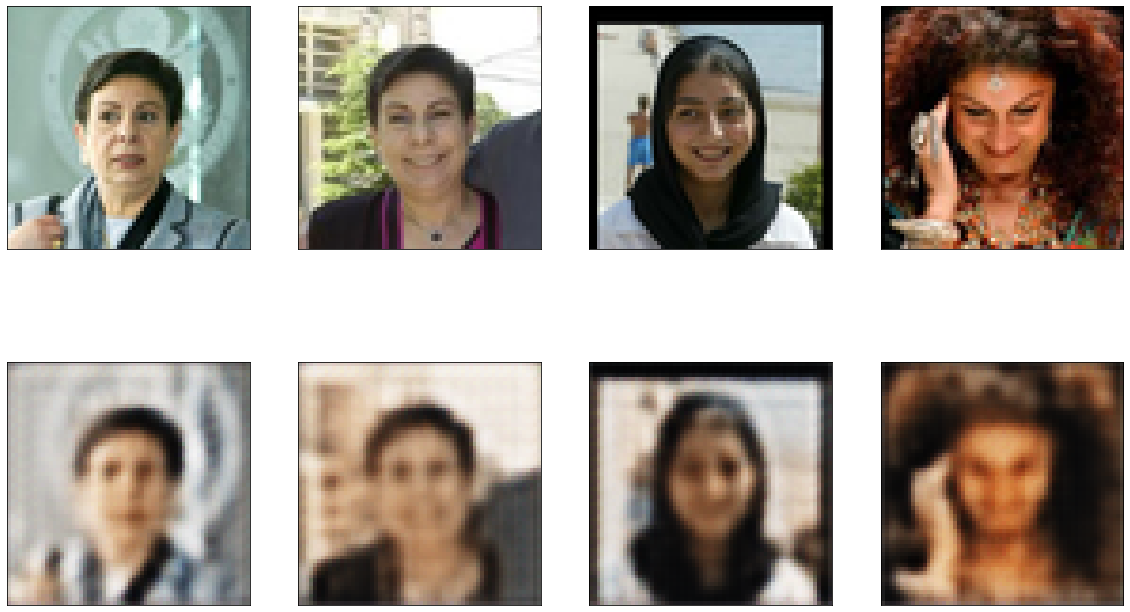

Running epoch 20/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:36 - loss: 0.0093 - acc: 0.721 - ETA: 2:31 - loss: 0.0093 - acc: 0.700 - ETA: 2:27 - loss: 0.0093 - acc: 0.703 - ETA: 2:23 - loss: 0.0091 - acc: 0.703 - ETA: 2:17 - loss: 0.0091 - acc: 0.708 - ETA: 2:13 - loss: 0.0090 - acc: 0.707 - ETA: 2:09 - loss: 0.0090 - acc: 0.709 - ETA: 2:05 - loss: 0.0089 - acc: 0.710 - ETA: 2:01 - loss: 0.0089 - acc: 0.712 - ETA: 1:57 - loss: 0.0088 - acc: 0.714 - ETA: 1:53 - loss: 0.0087 - acc: 0.715 - ETA: 1:49 - loss: 0.0087 - acc: 0.718 - ETA: 1:45 - loss: 0.0087 - acc: 0.719 - ETA: 1:41 - loss: 0.0087 - acc: 0.719 - ETA: 1:37 - loss: 0.0086 - acc: 0.719 - ETA: 1:33 - loss: 0.0086 - acc: 0.719 - ETA: 1:29 - loss: 0.0086 - acc: 0.719 - ETA: 1:25 - loss: 0.0086 - acc: 0.719 - ETA: 1:21 - loss: 0.0086 - acc: 0.721 - ETA: 1:17 - loss: 0.0086 - acc: 0.721 - ETA: 1:13 - loss: 0.0086 - acc: 0.723 - ETA: 1:09 - loss: 0.0086 - acc: 0.723 - ETA: 1:05 - loss: 0.0086 - acc: 0.723 - ETA: 

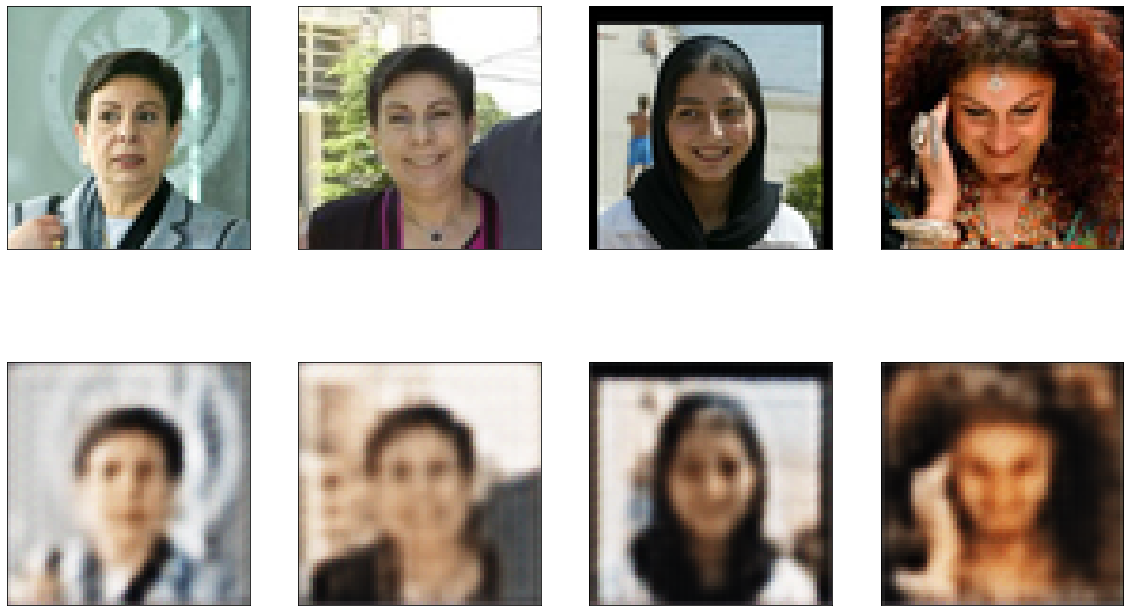

Running epoch 21/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:44 - loss: 0.0129 - acc: 0.710 - ETA: 2:35 - loss: 0.0123 - acc: 0.734 - ETA: 2:29 - loss: 0.0117 - acc: 0.732 - ETA: 2:24 - loss: 0.0115 - acc: 0.728 - ETA: 2:20 - loss: 0.0112 - acc: 0.728 - ETA: 2:15 - loss: 0.0111 - acc: 0.731 - ETA: 2:11 - loss: 0.0109 - acc: 0.728 - ETA: 2:06 - loss: 0.0109 - acc: 0.727 - ETA: 2:02 - loss: 0.0107 - acc: 0.727 - ETA: 1:58 - loss: 0.0106 - acc: 0.728 - ETA: 1:54 - loss: 0.0104 - acc: 0.727 - ETA: 1:50 - loss: 0.0103 - acc: 0.728 - ETA: 1:46 - loss: 0.0103 - acc: 0.729 - ETA: 1:42 - loss: 0.0102 - acc: 0.730 - ETA: 1:37 - loss: 0.0101 - acc: 0.731 - ETA: 1:33 - loss: 0.0100 - acc: 0.732 - ETA: 1:29 - loss: 0.0100 - acc: 0.731 - ETA: 1:25 - loss: 0.0099 - acc: 0.731 - ETA: 1:21 - loss: 0.0098 - acc: 0.730 - ETA: 1:17 - loss: 0.0098 - acc: 0.731 - ETA: 1:13 - loss: 0.0097 - acc: 0.731 - ETA: 1:09 - loss: 0.0096 - acc: 0.731 - ETA: 1:05 - loss: 0.0096 - acc: 0.731 - ETA: 

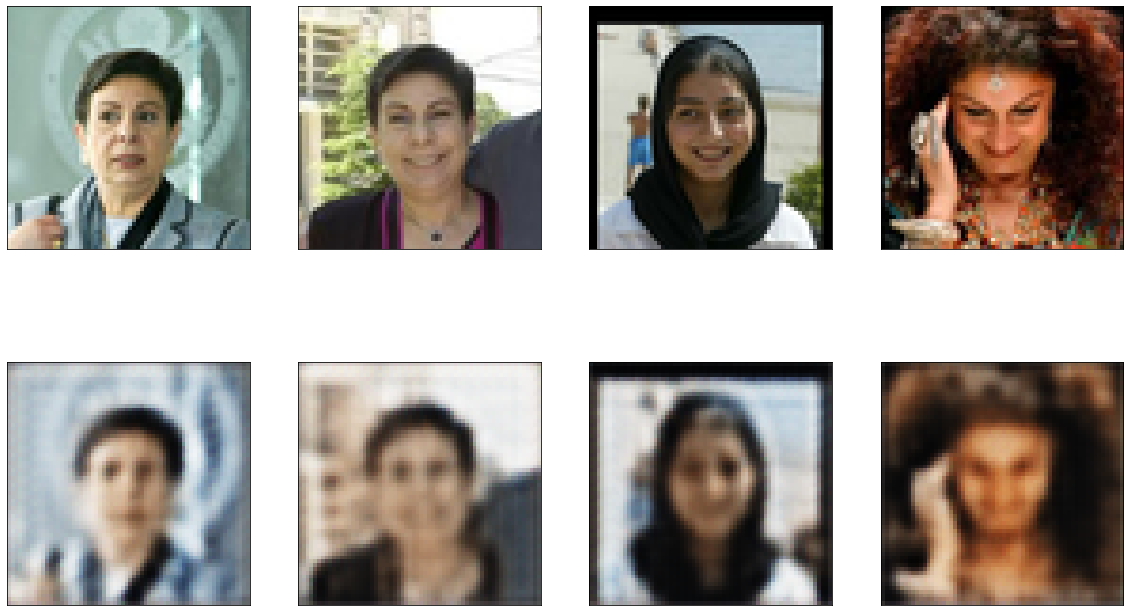

Running epoch 22/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:47 - loss: 0.0084 - acc: 0.726 - ETA: 2:36 - loss: 0.0087 - acc: 0.741 - ETA: 2:29 - loss: 0.0087 - acc: 0.741 - ETA: 2:23 - loss: 0.0088 - acc: 0.740 - ETA: 2:19 - loss: 0.0089 - acc: 0.742 - ETA: 2:14 - loss: 0.0089 - acc: 0.737 - ETA: 2:10 - loss: 0.0089 - acc: 0.734 - ETA: 2:06 - loss: 0.0090 - acc: 0.733 - ETA: 2:02 - loss: 0.0090 - acc: 0.733 - ETA: 1:57 - loss: 0.0091 - acc: 0.731 - ETA: 1:54 - loss: 0.0092 - acc: 0.732 - ETA: 1:49 - loss: 0.0092 - acc: 0.733 - ETA: 1:45 - loss: 0.0093 - acc: 0.734 - ETA: 1:41 - loss: 0.0095 - acc: 0.735 - ETA: 1:37 - loss: 0.0095 - acc: 0.736 - ETA: 1:33 - loss: 0.0096 - acc: 0.736 - ETA: 1:29 - loss: 0.0097 - acc: 0.737 - ETA: 1:25 - loss: 0.0097 - acc: 0.736 - ETA: 1:21 - loss: 0.0098 - acc: 0.738 - ETA: 1:17 - loss: 0.0098 - acc: 0.737 - ETA: 1:13 - loss: 0.0098 - acc: 0.738 - ETA: 1:09 - loss: 0.0098 - acc: 0.737 - ETA: 1:05 - loss: 0.0098 - acc: 0.737 - ETA: 

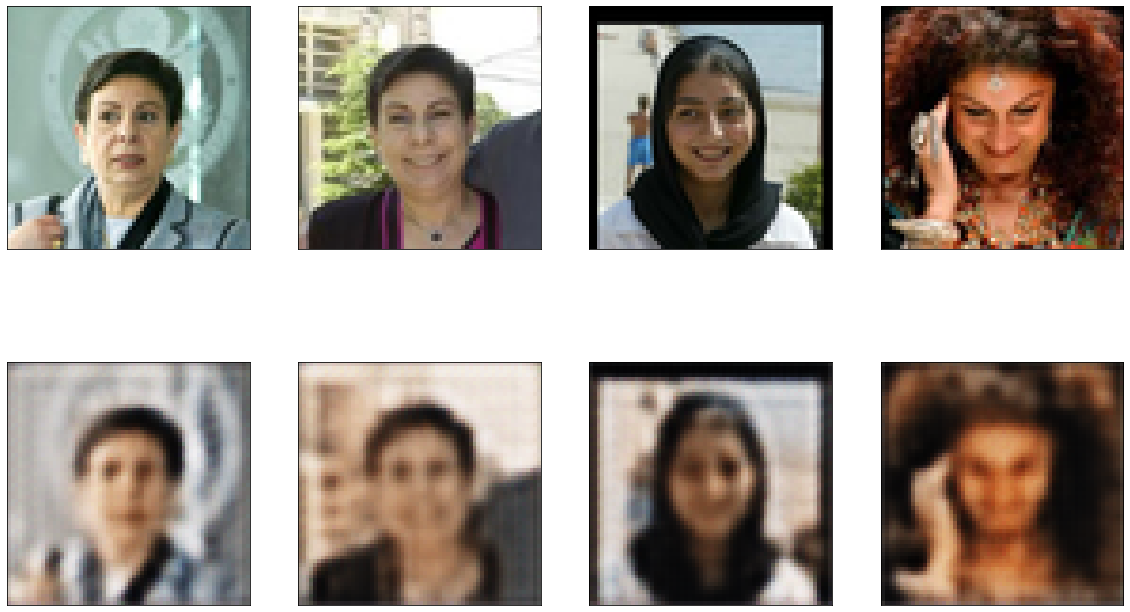

Running epoch 23/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:43 - loss: 0.0084 - acc: 0.708 - ETA: 2:34 - loss: 0.0084 - acc: 0.704 - ETA: 2:30 - loss: 0.0082 - acc: 0.708 - ETA: 2:26 - loss: 0.0082 - acc: 0.703 - ETA: 2:20 - loss: 0.0083 - acc: 0.706 - ETA: 2:15 - loss: 0.0082 - acc: 0.708 - ETA: 2:11 - loss: 0.0082 - acc: 0.708 - ETA: 2:07 - loss: 0.0082 - acc: 0.708 - ETA: 2:02 - loss: 0.0082 - acc: 0.710 - ETA: 1:58 - loss: 0.0083 - acc: 0.708 - ETA: 1:54 - loss: 0.0083 - acc: 0.708 - ETA: 1:51 - loss: 0.0083 - acc: 0.707 - ETA: 1:46 - loss: 0.0083 - acc: 0.708 - ETA: 1:42 - loss: 0.0083 - acc: 0.707 - ETA: 1:37 - loss: 0.0083 - acc: 0.707 - ETA: 1:33 - loss: 0.0083 - acc: 0.705 - ETA: 1:29 - loss: 0.0083 - acc: 0.708 - ETA: 1:25 - loss: 0.0083 - acc: 0.708 - ETA: 1:21 - loss: 0.0083 - acc: 0.710 - ETA: 1:17 - loss: 0.0082 - acc: 0.711 - ETA: 1:13 - loss: 0.0082 - acc: 0.712 - ETA: 1:09 - loss: 0.0082 - acc: 0.713 - ETA: 1:05 - loss: 0.0082 - acc: 0.713 - ETA: 

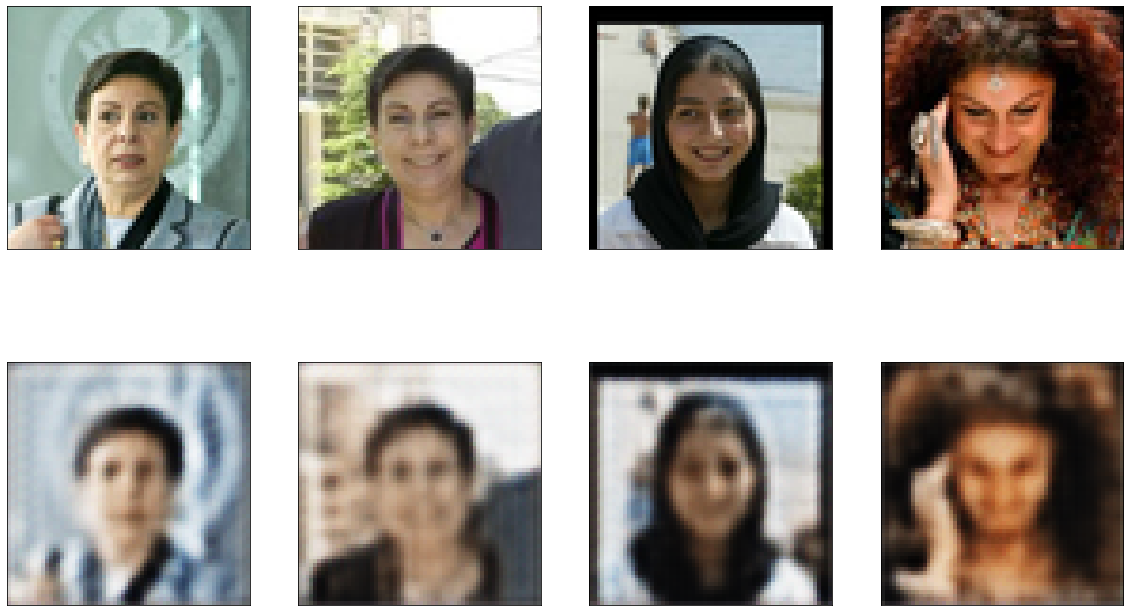

Running epoch 24/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:37 - loss: 0.0095 - acc: 0.732 - ETA: 2:30 - loss: 0.0094 - acc: 0.736 - ETA: 2:27 - loss: 0.0093 - acc: 0.731 - ETA: 2:24 - loss: 0.0093 - acc: 0.735 - ETA: 2:19 - loss: 0.0093 - acc: 0.737 - ETA: 2:15 - loss: 0.0093 - acc: 0.734 - ETA: 2:11 - loss: 0.0093 - acc: 0.735 - ETA: 2:07 - loss: 0.0093 - acc: 0.734 - ETA: 2:02 - loss: 0.0094 - acc: 0.735 - ETA: 1:58 - loss: 0.0094 - acc: 0.737 - ETA: 1:54 - loss: 0.0094 - acc: 0.737 - ETA: 1:49 - loss: 0.0094 - acc: 0.737 - ETA: 1:48 - loss: 0.0093 - acc: 0.738 - ETA: 1:46 - loss: 0.0094 - acc: 0.737 - ETA: 1:44 - loss: 0.0094 - acc: 0.738 - ETA: 1:42 - loss: 0.0094 - acc: 0.737 - ETA: 1:39 - loss: 0.0093 - acc: 0.737 - ETA: 1:36 - loss: 0.0093 - acc: 0.738 - ETA: 1:32 - loss: 0.0093 - acc: 0.738 - ETA: 1:28 - loss: 0.0092 - acc: 0.737 - ETA: 1:25 - loss: 0.0092 - acc: 0.737 - ETA: 1:20 - loss: 0.0092 - acc: 0.737 - ETA: 1:16 - loss: 0.0092 - acc: 0.737 - ETA: 

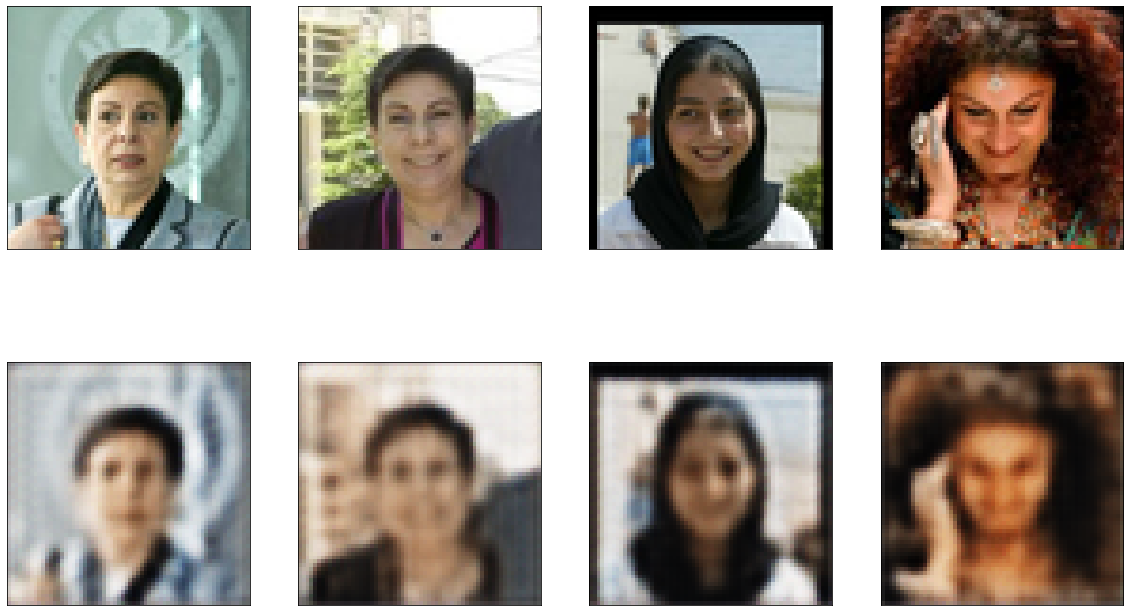

Running epoch 25/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:46 - loss: 0.0088 - acc: 0.727 - ETA: 3:35 - loss: 0.0089 - acc: 0.726 - ETA: 3:27 - loss: 0.0087 - acc: 0.731 - ETA: 3:21 - loss: 0.0087 - acc: 0.731 - ETA: 3:14 - loss: 0.0086 - acc: 0.728 - ETA: 3:08 - loss: 0.0086 - acc: 0.730 - ETA: 3:02 - loss: 0.0086 - acc: 0.730 - ETA: 2:57 - loss: 0.0086 - acc: 0.730 - ETA: 2:52 - loss: 0.0086 - acc: 0.729 - ETA: 2:46 - loss: 0.0085 - acc: 0.729 - ETA: 2:40 - loss: 0.0086 - acc: 0.729 - ETA: 2:34 - loss: 0.0086 - acc: 0.730 - ETA: 2:28 - loss: 0.0086 - acc: 0.730 - ETA: 2:22 - loss: 0.0085 - acc: 0.728 - ETA: 2:16 - loss: 0.0085 - acc: 0.728 - ETA: 2:11 - loss: 0.0085 - acc: 0.728 - ETA: 2:05 - loss: 0.0085 - acc: 0.728 - ETA: 1:59 - loss: 0.0085 - acc: 0.727 - ETA: 1:54 - loss: 0.0085 - acc: 0.726 - ETA: 1:48 - loss: 0.0085 - acc: 0.725 - ETA: 1:42 - loss: 0.0085 - acc: 0.723 - ETA: 1:37 - loss: 0.0085 - acc: 0.723 - ETA: 1:31 - loss: 0.0085 - acc: 0.723 - ETA: 

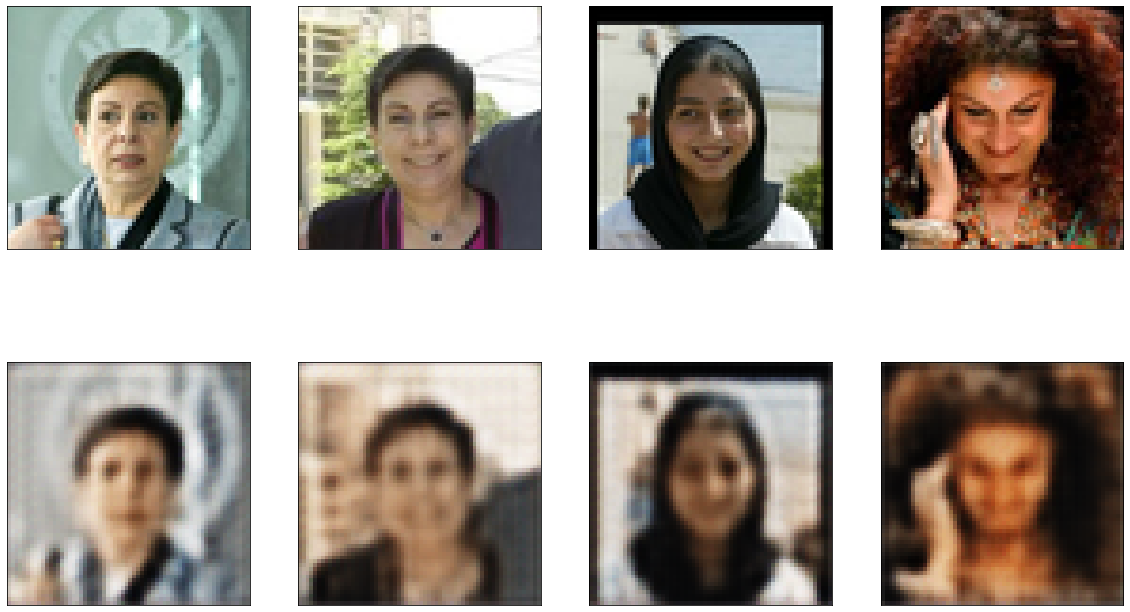

Running epoch 26/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:34 - loss: 0.0082 - acc: 0.725 - ETA: 3:28 - loss: 0.0082 - acc: 0.724 - ETA: 3:22 - loss: 0.0082 - acc: 0.726 - ETA: 3:17 - loss: 0.0082 - acc: 0.723 - ETA: 3:11 - loss: 0.0082 - acc: 0.726 - ETA: 3:06 - loss: 0.0082 - acc: 0.722 - ETA: 3:00 - loss: 0.0082 - acc: 0.724 - ETA: 2:55 - loss: 0.0082 - acc: 0.721 - ETA: 2:49 - loss: 0.0082 - acc: 0.722 - ETA: 2:43 - loss: 0.0082 - acc: 0.719 - ETA: 2:39 - loss: 0.0082 - acc: 0.720 - ETA: 2:33 - loss: 0.0081 - acc: 0.721 - ETA: 2:27 - loss: 0.0081 - acc: 0.722 - ETA: 2:21 - loss: 0.0081 - acc: 0.723 - ETA: 2:16 - loss: 0.0082 - acc: 0.724 - ETA: 2:10 - loss: 0.0082 - acc: 0.724 - ETA: 2:04 - loss: 0.0082 - acc: 0.726 - ETA: 1:58 - loss: 0.0083 - acc: 0.727 - ETA: 1:55 - loss: 0.0085 - acc: 0.728 - ETA: 1:50 - loss: 0.0086 - acc: 0.728 - ETA: 1:44 - loss: 0.0087 - acc: 0.729 - ETA: 1:38 - loss: 0.0089 - acc: 0.730 - ETA: 1:32 - loss: 0.0089 - acc: 0.731 - ETA: 

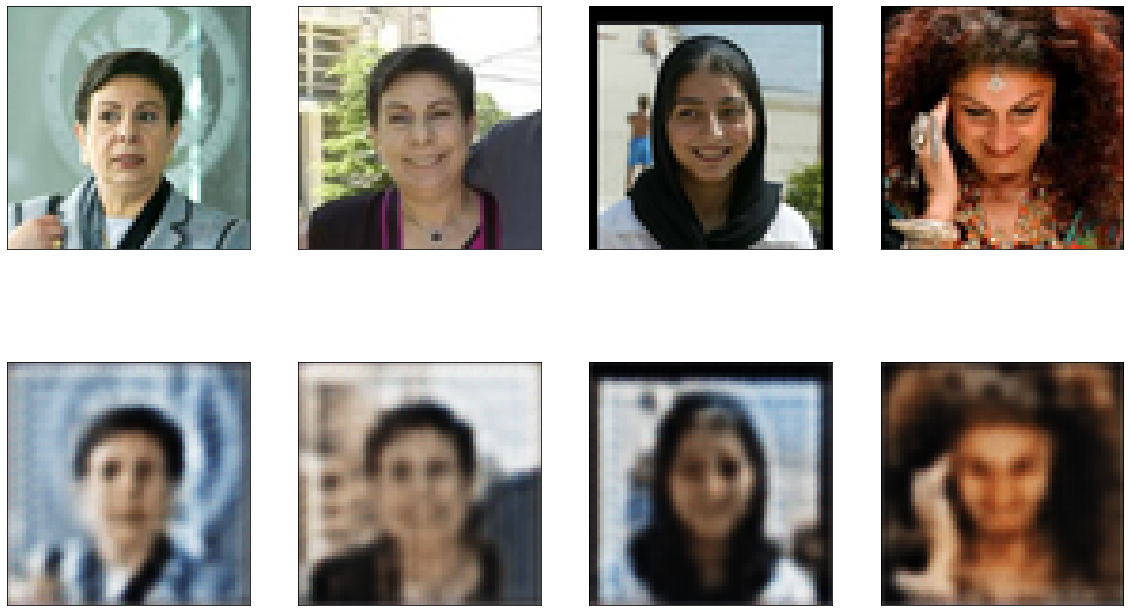

Running epoch 27/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:40 - loss: 0.0083 - acc: 0.719 - ETA: 3:33 - loss: 0.0085 - acc: 0.738 - ETA: 3:27 - loss: 0.0085 - acc: 0.734 - ETA: 3:20 - loss: 0.0084 - acc: 0.734 - ETA: 3:14 - loss: 0.0083 - acc: 0.732 - ETA: 3:08 - loss: 0.0084 - acc: 0.732 - ETA: 3:03 - loss: 0.0084 - acc: 0.727 - ETA: 2:58 - loss: 0.0084 - acc: 0.724 - ETA: 2:52 - loss: 0.0083 - acc: 0.726 - ETA: 2:46 - loss: 0.0083 - acc: 0.728 - ETA: 2:40 - loss: 0.0083 - acc: 0.724 - ETA: 2:34 - loss: 0.0083 - acc: 0.724 - ETA: 2:29 - loss: 0.0084 - acc: 0.720 - ETA: 2:23 - loss: 0.0084 - acc: 0.718 - ETA: 2:17 - loss: 0.0084 - acc: 0.717 - ETA: 2:11 - loss: 0.0084 - acc: 0.717 - ETA: 2:05 - loss: 0.0083 - acc: 0.718 - ETA: 1:59 - loss: 0.0083 - acc: 0.718 - ETA: 1:54 - loss: 0.0083 - acc: 0.719 - ETA: 1:48 - loss: 0.0083 - acc: 0.721 - ETA: 1:42 - loss: 0.0083 - acc: 0.722 - ETA: 1:38 - loss: 0.0082 - acc: 0.723 - ETA: 1:33 - loss: 0.0082 - acc: 0.724 - ETA: 

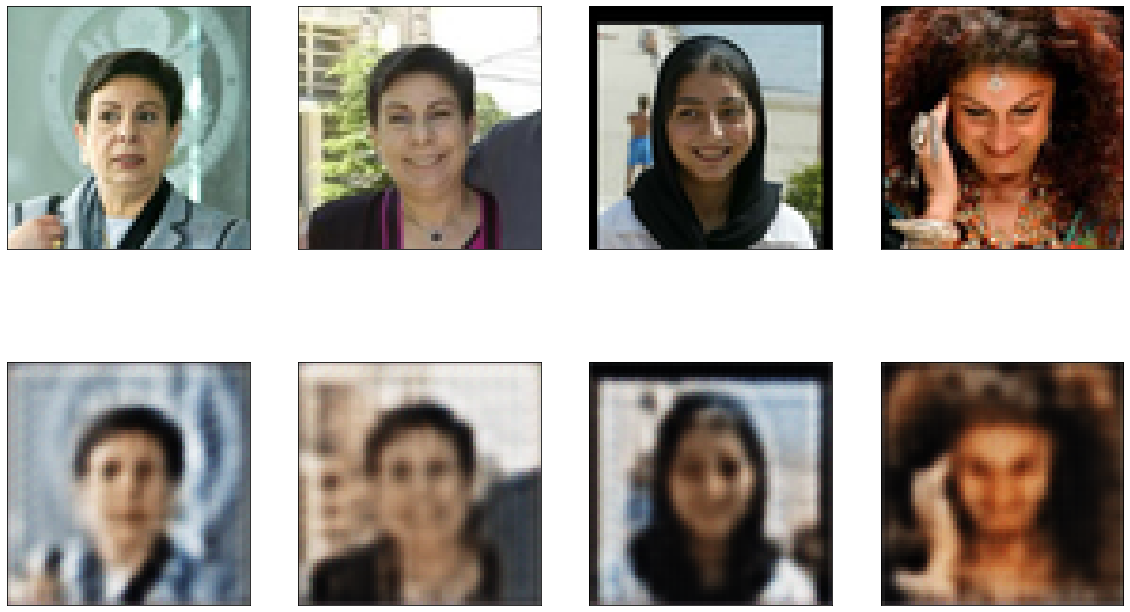

Running epoch 28/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:43 - loss: 0.0078 - acc: 0.732 - ETA: 3:33 - loss: 0.0080 - acc: 0.729 - ETA: 3:27 - loss: 0.0081 - acc: 0.731 - ETA: 3:21 - loss: 0.0083 - acc: 0.726 - ETA: 3:16 - loss: 0.0085 - acc: 0.730 - ETA: 3:09 - loss: 0.0086 - acc: 0.733 - ETA: 3:03 - loss: 0.0087 - acc: 0.731 - ETA: 2:57 - loss: 0.0087 - acc: 0.729 - ETA: 2:51 - loss: 0.0088 - acc: 0.732 - ETA: 2:45 - loss: 0.0088 - acc: 0.733 - ETA: 2:40 - loss: 0.0088 - acc: 0.733 - ETA: 2:34 - loss: 0.0089 - acc: 0.733 - ETA: 2:28 - loss: 0.0089 - acc: 0.734 - ETA: 2:22 - loss: 0.0090 - acc: 0.733 - ETA: 2:17 - loss: 0.0090 - acc: 0.733 - ETA: 2:11 - loss: 0.0091 - acc: 0.733 - ETA: 2:05 - loss: 0.0092 - acc: 0.732 - ETA: 1:59 - loss: 0.0092 - acc: 0.732 - ETA: 1:54 - loss: 0.0092 - acc: 0.732 - ETA: 1:48 - loss: 0.0091 - acc: 0.731 - ETA: 1:43 - loss: 0.0092 - acc: 0.731 - ETA: 1:37 - loss: 0.0092 - acc: 0.731 - ETA: 1:31 - loss: 0.0091 - acc: 0.731 - ETA: 

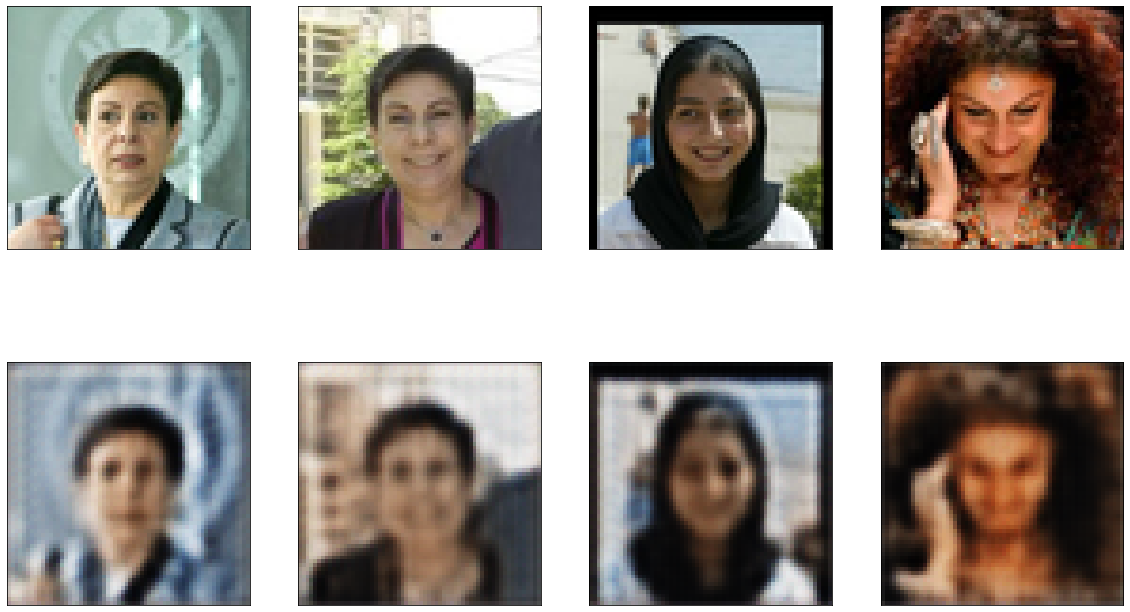

Running epoch 29/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:45 - loss: 0.0087 - acc: 0.736 - ETA: 3:34 - loss: 0.0086 - acc: 0.736 - ETA: 3:27 - loss: 0.0085 - acc: 0.735 - ETA: 3:21 - loss: 0.0085 - acc: 0.734 - ETA: 3:17 - loss: 0.0085 - acc: 0.729 - ETA: 3:06 - loss: 0.0086 - acc: 0.728 - ETA: 2:59 - loss: 0.0086 - acc: 0.728 - ETA: 2:49 - loss: 0.0087 - acc: 0.727 - ETA: 2:39 - loss: 0.0087 - acc: 0.728 - ETA: 2:30 - loss: 0.0088 - acc: 0.726 - ETA: 2:22 - loss: 0.0088 - acc: 0.726 - ETA: 2:14 - loss: 0.0089 - acc: 0.725 - ETA: 2:08 - loss: 0.0089 - acc: 0.726 - ETA: 2:01 - loss: 0.0089 - acc: 0.727 - ETA: 1:55 - loss: 0.0089 - acc: 0.728 - ETA: 1:49 - loss: 0.0089 - acc: 0.728 - ETA: 1:43 - loss: 0.0089 - acc: 0.730 - ETA: 1:38 - loss: 0.0090 - acc: 0.732 - ETA: 1:33 - loss: 0.0090 - acc: 0.732 - ETA: 1:28 - loss: 0.0090 - acc: 0.732 - ETA: 1:22 - loss: 0.0090 - acc: 0.733 - ETA: 1:17 - loss: 0.0090 - acc: 0.734 - ETA: 1:12 - loss: 0.0090 - acc: 0.734 - ETA: 

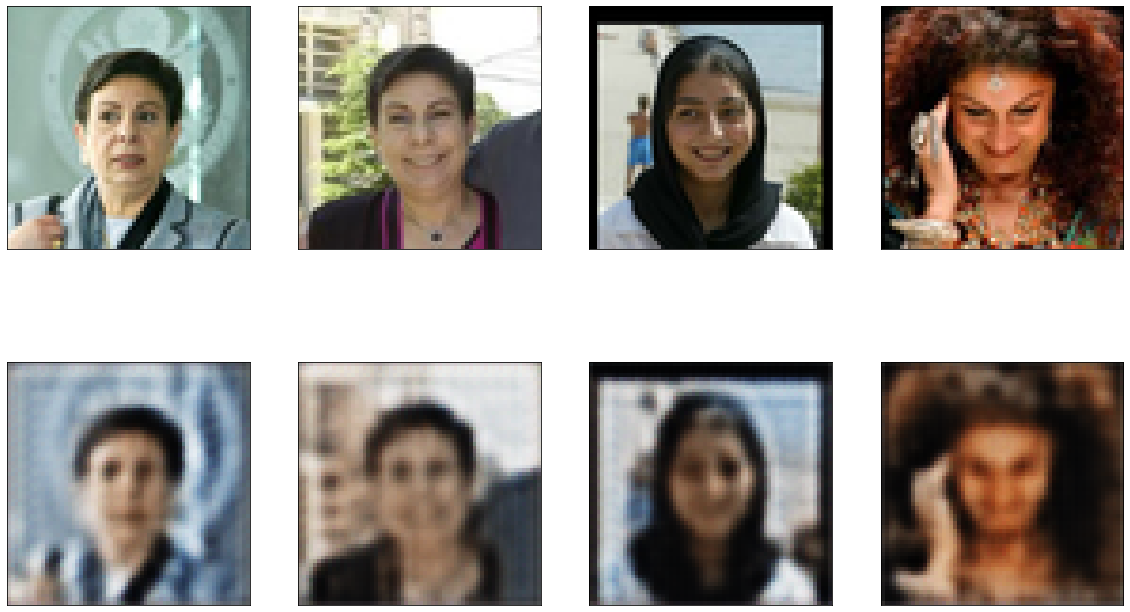

Running epoch 30/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:44 - loss: 0.0087 - acc: 0.736 - ETA: 2:31 - loss: 0.0089 - acc: 0.731 - ETA: 2:28 - loss: 0.0092 - acc: 0.739 - ETA: 2:23 - loss: 0.0092 - acc: 0.737 - ETA: 2:19 - loss: 0.0092 - acc: 0.744 - ETA: 2:14 - loss: 0.0092 - acc: 0.743 - ETA: 2:10 - loss: 0.0093 - acc: 0.746 - ETA: 2:06 - loss: 0.0092 - acc: 0.743 - ETA: 2:02 - loss: 0.0093 - acc: 0.744 - ETA: 1:59 - loss: 0.0093 - acc: 0.741 - ETA: 1:55 - loss: 0.0092 - acc: 0.739 - ETA: 1:51 - loss: 0.0092 - acc: 0.738 - ETA: 1:47 - loss: 0.0092 - acc: 0.738 - ETA: 1:43 - loss: 0.0092 - acc: 0.738 - ETA: 1:39 - loss: 0.0092 - acc: 0.740 - ETA: 1:34 - loss: 0.0092 - acc: 0.739 - ETA: 1:30 - loss: 0.0091 - acc: 0.740 - ETA: 1:26 - loss: 0.0091 - acc: 0.741 - ETA: 1:22 - loss: 0.0091 - acc: 0.741 - ETA: 1:17 - loss: 0.0091 - acc: 0.741 - ETA: 1:13 - loss: 0.0091 - acc: 0.741 - ETA: 1:09 - loss: 0.0091 - acc: 0.740 - ETA: 1:05 - loss: 0.0091 - acc: 0.740 - ETA: 

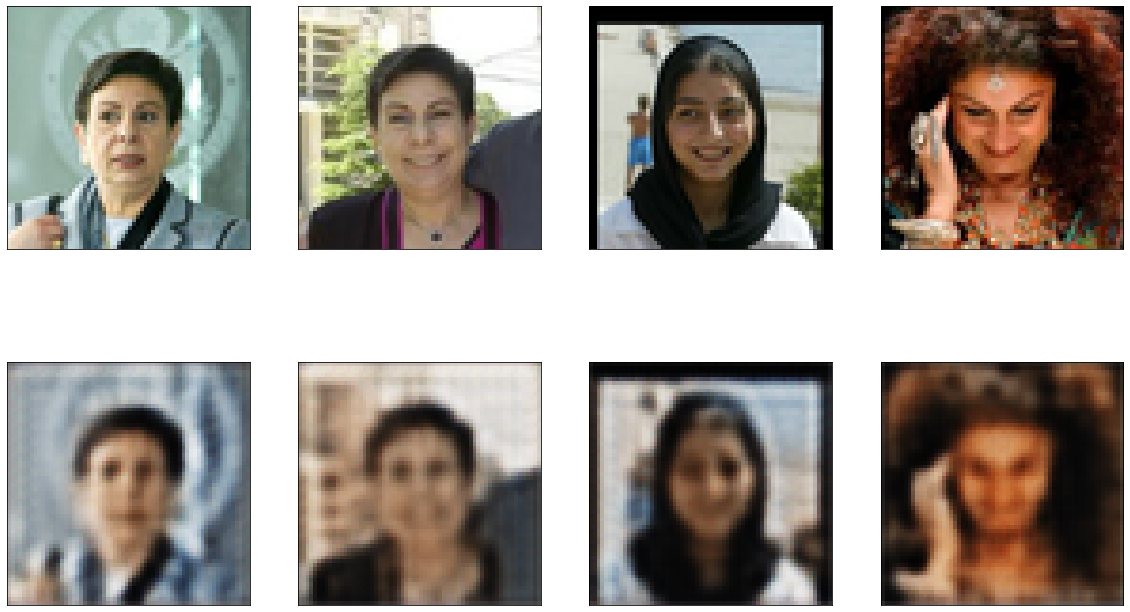

Running epoch 31/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:43 - loss: 0.0090 - acc: 0.733 - ETA: 2:33 - loss: 0.0090 - acc: 0.731 - ETA: 2:27 - loss: 0.0092 - acc: 0.729 - ETA: 2:23 - loss: 0.0092 - acc: 0.727 - ETA: 2:18 - loss: 0.0093 - acc: 0.730 - ETA: 2:14 - loss: 0.0093 - acc: 0.731 - ETA: 2:10 - loss: 0.0093 - acc: 0.732 - ETA: 2:06 - loss: 0.0093 - acc: 0.732 - ETA: 2:02 - loss: 0.0093 - acc: 0.733 - ETA: 1:58 - loss: 0.0092 - acc: 0.735 - ETA: 1:54 - loss: 0.0092 - acc: 0.737 - ETA: 1:49 - loss: 0.0092 - acc: 0.737 - ETA: 1:45 - loss: 0.0092 - acc: 0.738 - ETA: 1:41 - loss: 0.0093 - acc: 0.739 - ETA: 1:37 - loss: 0.0093 - acc: 0.737 - ETA: 1:33 - loss: 0.0093 - acc: 0.737 - ETA: 1:29 - loss: 0.0093 - acc: 0.736 - ETA: 1:25 - loss: 0.0093 - acc: 0.735 - ETA: 1:21 - loss: 0.0093 - acc: 0.735 - ETA: 1:17 - loss: 0.0093 - acc: 0.737 - ETA: 1:13 - loss: 0.0094 - acc: 0.736 - ETA: 1:09 - loss: 0.0094 - acc: 0.736 - ETA: 1:05 - loss: 0.0094 - acc: 0.737 - ETA: 

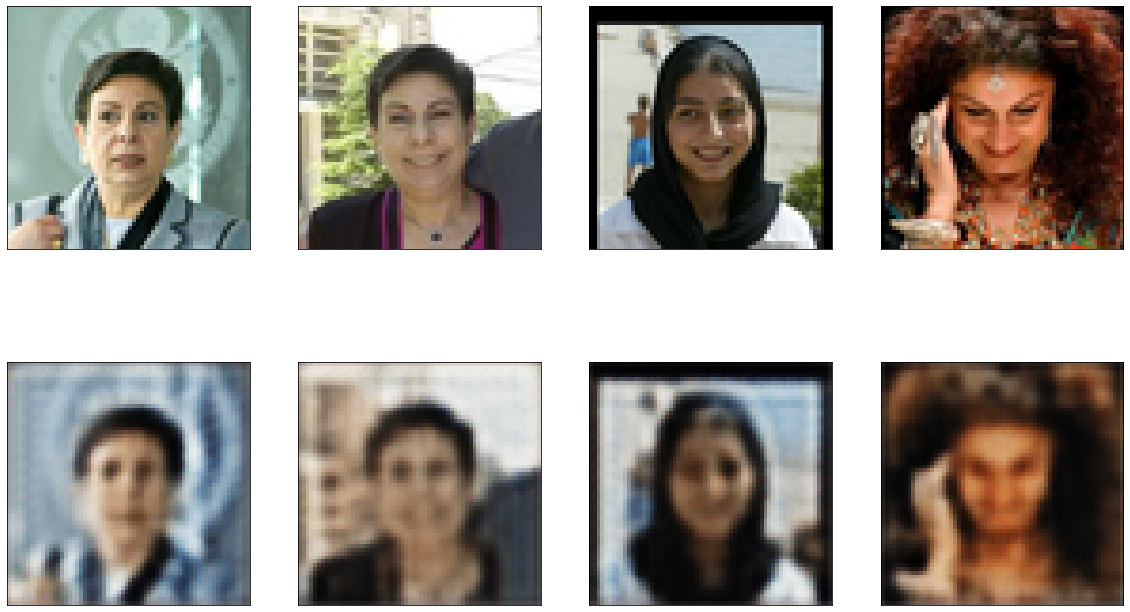

Running epoch 32/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:39 - loss: 0.0081 - acc: 0.756 - ETA: 2:39 - loss: 0.0082 - acc: 0.743 - ETA: 2:42 - loss: 0.0083 - acc: 0.742 - ETA: 2:38 - loss: 0.0083 - acc: 0.744 - ETA: 2:31 - loss: 0.0085 - acc: 0.745 - ETA: 2:24 - loss: 0.0085 - acc: 0.744 - ETA: 2:18 - loss: 0.0086 - acc: 0.743 - ETA: 2:12 - loss: 0.0086 - acc: 0.740 - ETA: 2:07 - loss: 0.0087 - acc: 0.738 - ETA: 2:02 - loss: 0.0088 - acc: 0.737 - ETA: 1:58 - loss: 0.0088 - acc: 0.737 - ETA: 1:53 - loss: 0.0088 - acc: 0.736 - ETA: 1:49 - loss: 0.0088 - acc: 0.738 - ETA: 1:45 - loss: 0.0088 - acc: 0.739 - ETA: 1:40 - loss: 0.0089 - acc: 0.737 - ETA: 1:36 - loss: 0.0089 - acc: 0.736 - ETA: 1:31 - loss: 0.0089 - acc: 0.737 - ETA: 1:27 - loss: 0.0089 - acc: 0.737 - ETA: 1:23 - loss: 0.0089 - acc: 0.738 - ETA: 1:19 - loss: 0.0089 - acc: 0.739 - ETA: 1:14 - loss: 0.0089 - acc: 0.739 - ETA: 1:10 - loss: 0.0089 - acc: 0.740 - ETA: 1:06 - loss: 0.0089 - acc: 0.740 - ETA: 

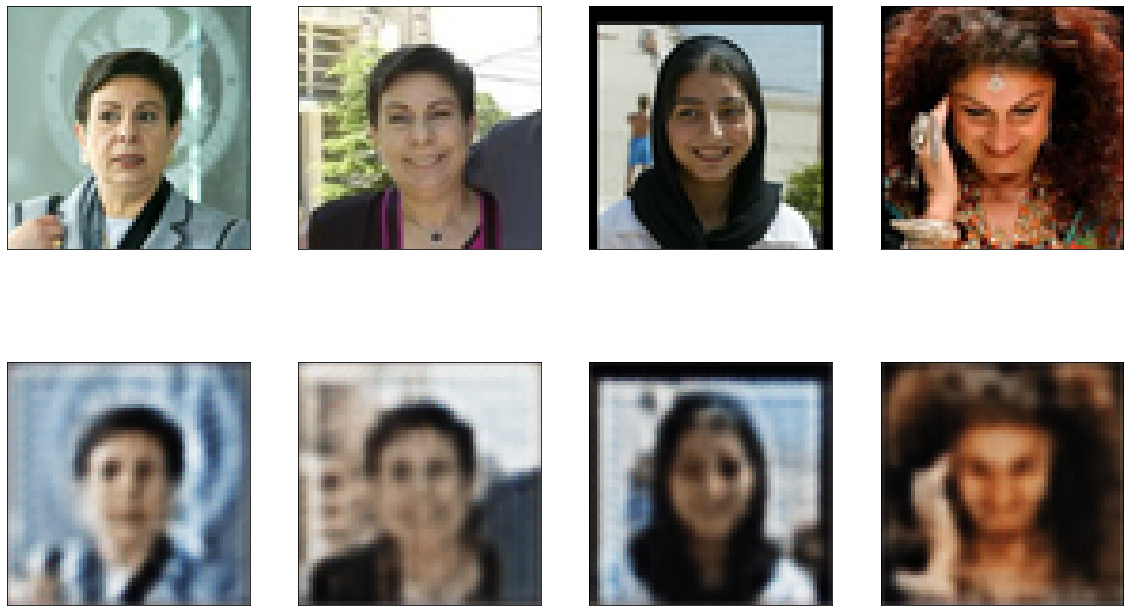

Running epoch 33/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:45 - loss: 0.0081 - acc: 0.726 - ETA: 2:38 - loss: 0.0081 - acc: 0.732 - ETA: 2:29 - loss: 0.0080 - acc: 0.736 - ETA: 2:25 - loss: 0.0079 - acc: 0.727 - ETA: 2:20 - loss: 0.0080 - acc: 0.721 - ETA: 2:16 - loss: 0.0080 - acc: 0.724 - ETA: 2:12 - loss: 0.0080 - acc: 0.726 - ETA: 2:07 - loss: 0.0080 - acc: 0.727 - ETA: 2:03 - loss: 0.0080 - acc: 0.726 - ETA: 1:59 - loss: 0.0080 - acc: 0.728 - ETA: 1:54 - loss: 0.0080 - acc: 0.729 - ETA: 1:50 - loss: 0.0079 - acc: 0.729 - ETA: 1:46 - loss: 0.0079 - acc: 0.727 - ETA: 1:42 - loss: 0.0079 - acc: 0.727 - ETA: 1:38 - loss: 0.0079 - acc: 0.727 - ETA: 1:34 - loss: 0.0079 - acc: 0.727 - ETA: 1:30 - loss: 0.0079 - acc: 0.726 - ETA: 1:26 - loss: 0.0079 - acc: 0.728 - ETA: 1:22 - loss: 0.0079 - acc: 0.725 - ETA: 1:18 - loss: 0.0079 - acc: 0.725 - ETA: 1:13 - loss: 0.0079 - acc: 0.725 - ETA: 1:09 - loss: 0.0079 - acc: 0.725 - ETA: 1:05 - loss: 0.0079 - acc: 0.724 - ETA: 

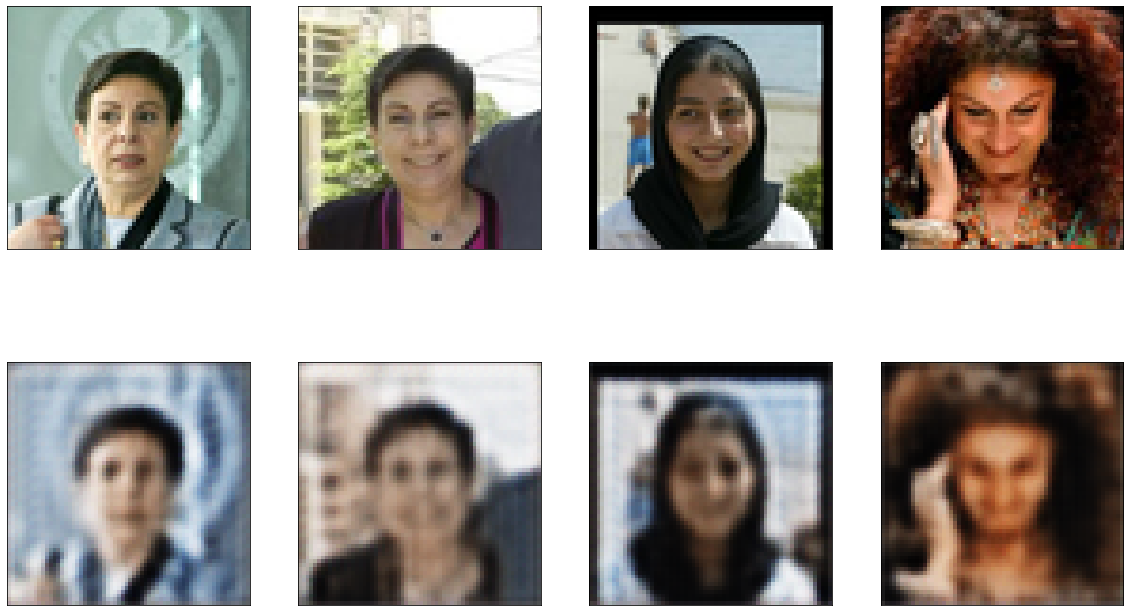

Running epoch 34/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:39 - loss: 0.0074 - acc: 0.740 - ETA: 2:33 - loss: 0.0076 - acc: 0.747 - ETA: 2:27 - loss: 0.0076 - acc: 0.744 - ETA: 2:22 - loss: 0.0075 - acc: 0.742 - ETA: 2:18 - loss: 0.0075 - acc: 0.743 - ETA: 2:13 - loss: 0.0075 - acc: 0.740 - ETA: 2:09 - loss: 0.0075 - acc: 0.738 - ETA: 2:05 - loss: 0.0075 - acc: 0.735 - ETA: 2:01 - loss: 0.0076 - acc: 0.735 - ETA: 1:57 - loss: 0.0076 - acc: 0.736 - ETA: 1:52 - loss: 0.0076 - acc: 0.737 - ETA: 1:49 - loss: 0.0076 - acc: 0.739 - ETA: 1:45 - loss: 0.0077 - acc: 0.739 - ETA: 1:41 - loss: 0.0077 - acc: 0.739 - ETA: 1:37 - loss: 0.0078 - acc: 0.739 - ETA: 1:33 - loss: 0.0080 - acc: 0.740 - ETA: 1:29 - loss: 0.0081 - acc: 0.740 - ETA: 1:26 - loss: 0.0083 - acc: 0.739 - ETA: 1:24 - loss: 0.0084 - acc: 0.739 - ETA: 1:21 - loss: 0.0085 - acc: 0.739 - ETA: 1:18 - loss: 0.0085 - acc: 0.739 - ETA: 1:15 - loss: 0.0085 - acc: 0.740 - ETA: 1:11 - loss: 0.0086 - acc: 0.740 - ETA: 

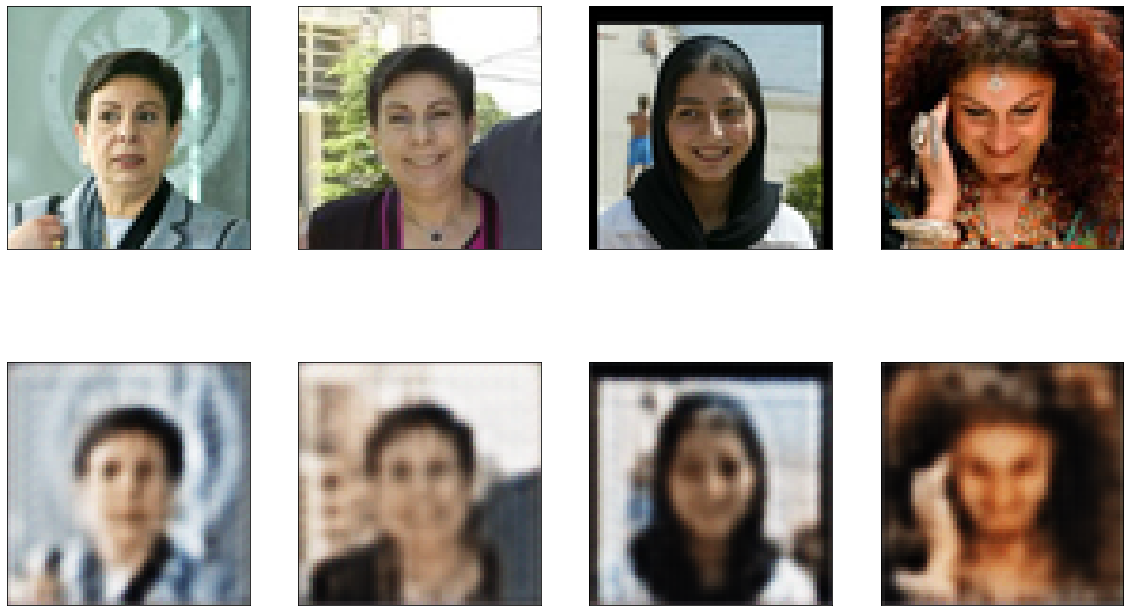

Running epoch 35/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:39 - loss: 0.0085 - acc: 0.731 - ETA: 3:30 - loss: 0.0083 - acc: 0.741 - ETA: 3:23 - loss: 0.0083 - acc: 0.746 - ETA: 3:18 - loss: 0.0082 - acc: 0.744 - ETA: 3:12 - loss: 0.0082 - acc: 0.743 - ETA: 3:07 - loss: 0.0081 - acc: 0.743 - ETA: 3:02 - loss: 0.0081 - acc: 0.743 - ETA: 2:57 - loss: 0.0080 - acc: 0.742 - ETA: 2:53 - loss: 0.0080 - acc: 0.740 - ETA: 2:50 - loss: 0.0080 - acc: 0.741 - ETA: 2:46 - loss: 0.0080 - acc: 0.743 - ETA: 2:42 - loss: 0.0080 - acc: 0.742 - ETA: 2:37 - loss: 0.0080 - acc: 0.743 - ETA: 2:31 - loss: 0.0081 - acc: 0.745 - ETA: 2:26 - loss: 0.0081 - acc: 0.745 - ETA: 2:21 - loss: 0.0081 - acc: 0.745 - ETA: 2:15 - loss: 0.0082 - acc: 0.746 - ETA: 2:10 - loss: 0.0083 - acc: 0.745 - ETA: 2:04 - loss: 0.0083 - acc: 0.746 - ETA: 1:58 - loss: 0.0083 - acc: 0.745 - ETA: 1:52 - loss: 0.0084 - acc: 0.745 - ETA: 1:46 - loss: 0.0084 - acc: 0.745 - ETA: 1:40 - loss: 0.0085 - acc: 0.745 - ETA: 

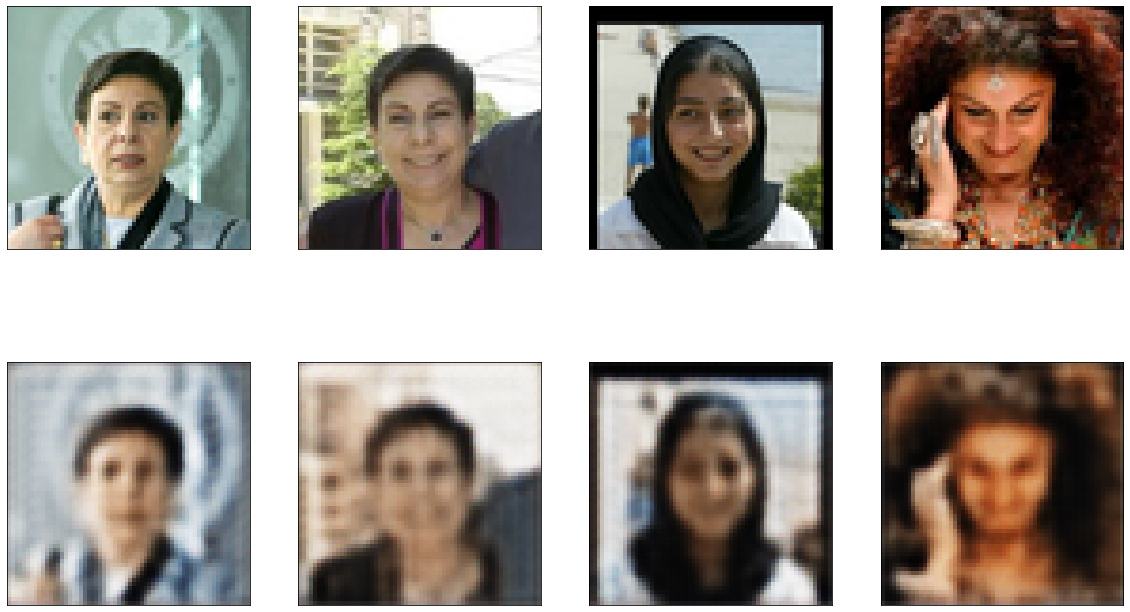

Running epoch 36/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:40 - loss: 0.0078 - acc: 0.744 - ETA: 3:31 - loss: 0.0078 - acc: 0.738 - ETA: 3:24 - loss: 0.0078 - acc: 0.740 - ETA: 3:18 - loss: 0.0078 - acc: 0.742 - ETA: 3:12 - loss: 0.0078 - acc: 0.740 - ETA: 3:06 - loss: 0.0077 - acc: 0.738 - ETA: 3:01 - loss: 0.0077 - acc: 0.740 - ETA: 2:55 - loss: 0.0077 - acc: 0.739 - ETA: 2:49 - loss: 0.0077 - acc: 0.737 - ETA: 2:44 - loss: 0.0077 - acc: 0.736 - ETA: 2:38 - loss: 0.0077 - acc: 0.737 - ETA: 2:33 - loss: 0.0077 - acc: 0.737 - ETA: 2:27 - loss: 0.0078 - acc: 0.736 - ETA: 2:21 - loss: 0.0078 - acc: 0.734 - ETA: 2:16 - loss: 0.0078 - acc: 0.733 - ETA: 2:10 - loss: 0.0078 - acc: 0.730 - ETA: 2:05 - loss: 0.0078 - acc: 0.728 - ETA: 1:59 - loss: 0.0079 - acc: 0.726 - ETA: 1:53 - loss: 0.0079 - acc: 0.726 - ETA: 1:48 - loss: 0.0079 - acc: 0.725 - ETA: 1:42 - loss: 0.0079 - acc: 0.725 - ETA: 1:37 - loss: 0.0079 - acc: 0.725 - ETA: 1:31 - loss: 0.0079 - acc: 0.725 - ETA: 

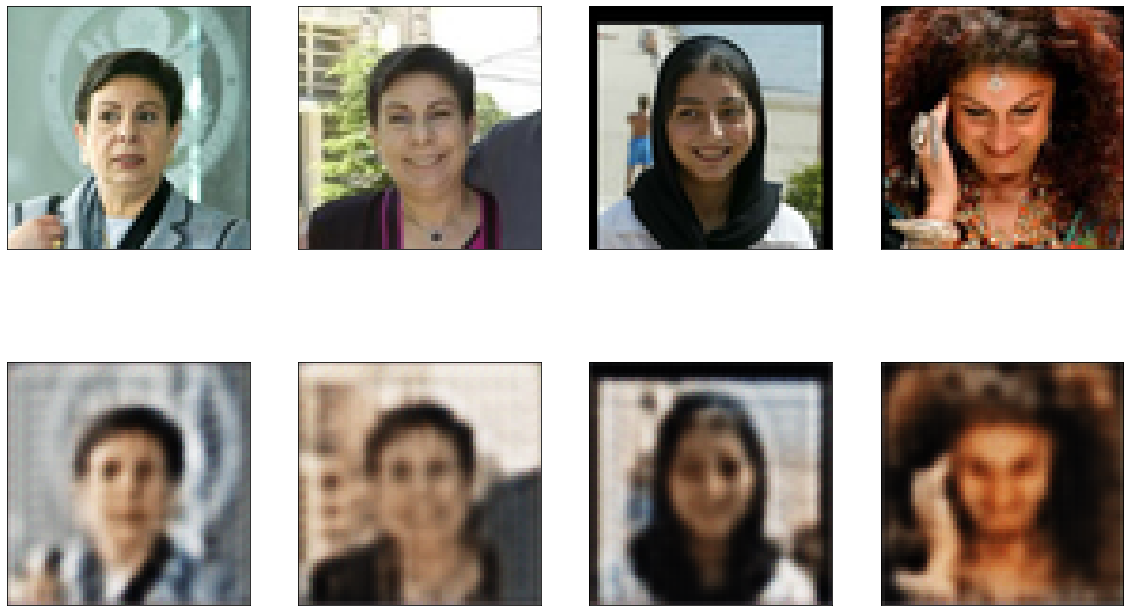

Running epoch 37/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:43 - loss: 0.0075 - acc: 0.719 - ETA: 3:33 - loss: 0.0078 - acc: 0.727 - ETA: 3:25 - loss: 0.0079 - acc: 0.729 - ETA: 3:15 - loss: 0.0079 - acc: 0.731 - ETA: 3:09 - loss: 0.0079 - acc: 0.733 - ETA: 2:55 - loss: 0.0078 - acc: 0.737 - ETA: 2:44 - loss: 0.0079 - acc: 0.736 - ETA: 2:35 - loss: 0.0081 - acc: 0.737 - ETA: 2:26 - loss: 0.0082 - acc: 0.738 - ETA: 2:20 - loss: 0.0084 - acc: 0.738 - ETA: 2:13 - loss: 0.0085 - acc: 0.738 - ETA: 2:06 - loss: 0.0087 - acc: 0.739 - ETA: 2:00 - loss: 0.0088 - acc: 0.741 - ETA: 1:55 - loss: 0.0088 - acc: 0.739 - ETA: 1:49 - loss: 0.0089 - acc: 0.739 - ETA: 1:44 - loss: 0.0089 - acc: 0.740 - ETA: 1:38 - loss: 0.0089 - acc: 0.739 - ETA: 1:34 - loss: 0.0089 - acc: 0.740 - ETA: 1:29 - loss: 0.0089 - acc: 0.740 - ETA: 1:25 - loss: 0.0089 - acc: 0.741 - ETA: 1:20 - loss: 0.0089 - acc: 0.741 - ETA: 1:15 - loss: 0.0089 - acc: 0.741 - ETA: 1:11 - loss: 0.0089 - acc: 0.742 - ETA: 

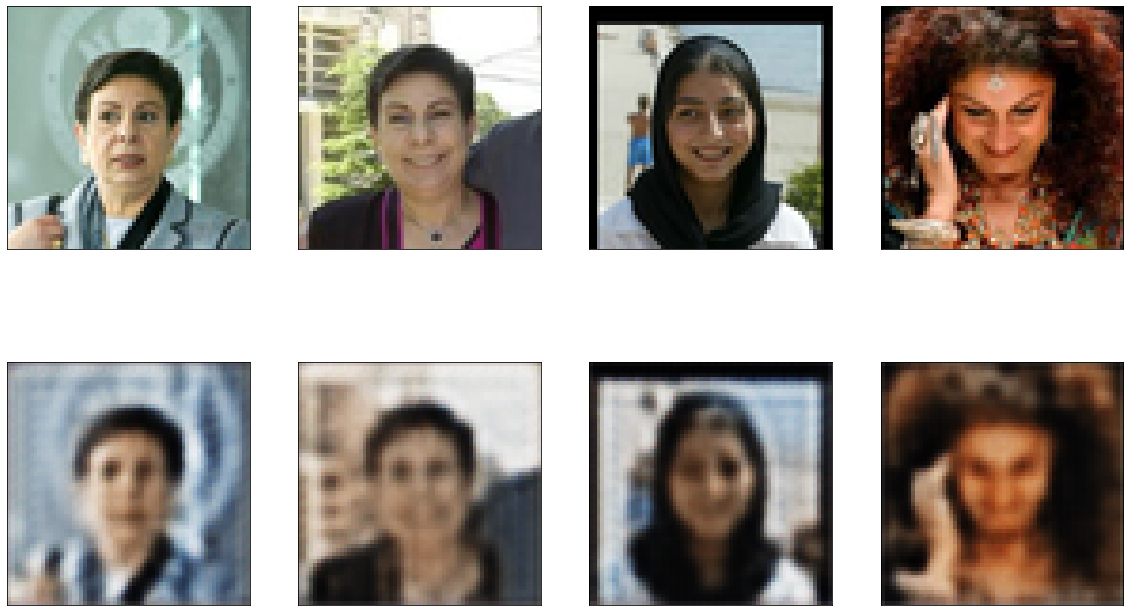

Running epoch 38/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:40 - loss: 0.0076 - acc: 0.749 - ETA: 2:33 - loss: 0.0078 - acc: 0.756 - ETA: 2:27 - loss: 0.0079 - acc: 0.754 - ETA: 2:23 - loss: 0.0078 - acc: 0.748 - ETA: 2:18 - loss: 0.0079 - acc: 0.746 - ETA: 2:14 - loss: 0.0079 - acc: 0.746 - ETA: 2:10 - loss: 0.0078 - acc: 0.745 - ETA: 2:06 - loss: 0.0078 - acc: 0.741 - ETA: 2:03 - loss: 0.0079 - acc: 0.741 - ETA: 1:58 - loss: 0.0078 - acc: 0.743 - ETA: 1:54 - loss: 0.0078 - acc: 0.741 - ETA: 1:50 - loss: 0.0078 - acc: 0.741 - ETA: 1:46 - loss: 0.0078 - acc: 0.741 - ETA: 1:42 - loss: 0.0078 - acc: 0.741 - ETA: 1:38 - loss: 0.0078 - acc: 0.742 - ETA: 1:33 - loss: 0.0078 - acc: 0.743 - ETA: 1:30 - loss: 0.0078 - acc: 0.743 - ETA: 1:25 - loss: 0.0078 - acc: 0.745 - ETA: 1:21 - loss: 0.0079 - acc: 0.744 - ETA: 1:17 - loss: 0.0079 - acc: 0.743 - ETA: 1:13 - loss: 0.0080 - acc: 0.742 - ETA: 1:09 - loss: 0.0081 - acc: 0.743 - ETA: 1:05 - loss: 0.0081 - acc: 0.742 - ETA: 

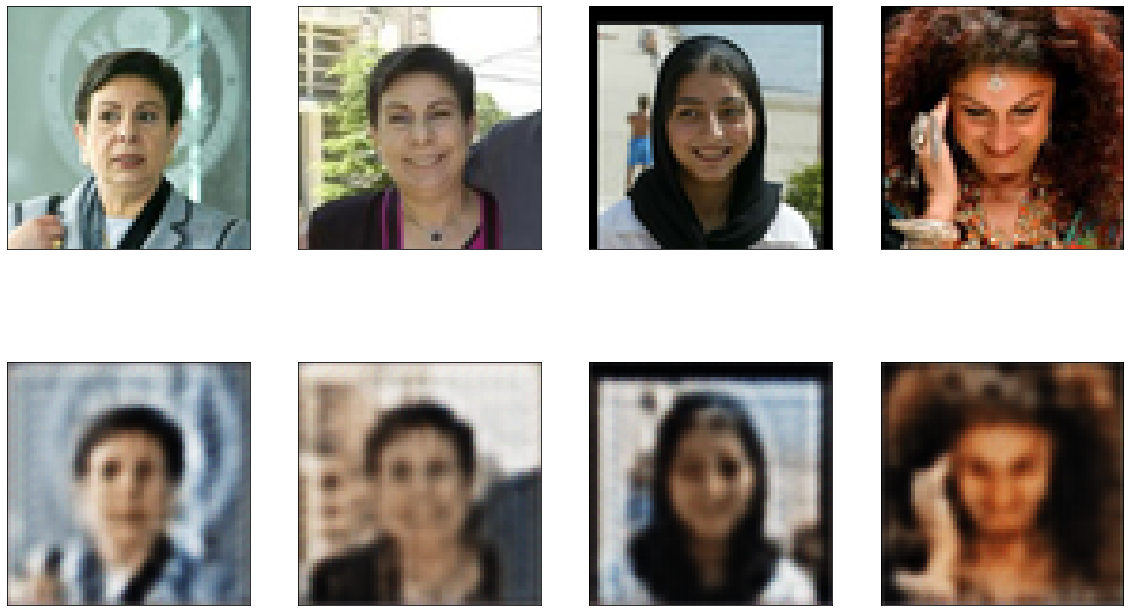

Running epoch 39/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:39 - loss: 0.0078 - acc: 0.773 - ETA: 2:33 - loss: 0.0079 - acc: 0.756 - ETA: 2:28 - loss: 0.0080 - acc: 0.752 - ETA: 2:23 - loss: 0.0080 - acc: 0.747 - ETA: 2:20 - loss: 0.0079 - acc: 0.747 - ETA: 2:15 - loss: 0.0079 - acc: 0.749 - ETA: 2:10 - loss: 0.0080 - acc: 0.747 - ETA: 2:06 - loss: 0.0080 - acc: 0.745 - ETA: 2:02 - loss: 0.0080 - acc: 0.748 - ETA: 1:58 - loss: 0.0080 - acc: 0.746 - ETA: 1:54 - loss: 0.0080 - acc: 0.748 - ETA: 1:50 - loss: 0.0080 - acc: 0.749 - ETA: 1:46 - loss: 0.0080 - acc: 0.748 - ETA: 1:42 - loss: 0.0081 - acc: 0.748 - ETA: 1:38 - loss: 0.0081 - acc: 0.749 - ETA: 1:34 - loss: 0.0081 - acc: 0.748 - ETA: 1:30 - loss: 0.0081 - acc: 0.747 - ETA: 1:26 - loss: 0.0082 - acc: 0.746 - ETA: 1:22 - loss: 0.0082 - acc: 0.745 - ETA: 1:17 - loss: 0.0083 - acc: 0.744 - ETA: 1:13 - loss: 0.0083 - acc: 0.741 - ETA: 1:09 - loss: 0.0084 - acc: 0.741 - ETA: 1:05 - loss: 0.0084 - acc: 0.740 - ETA: 

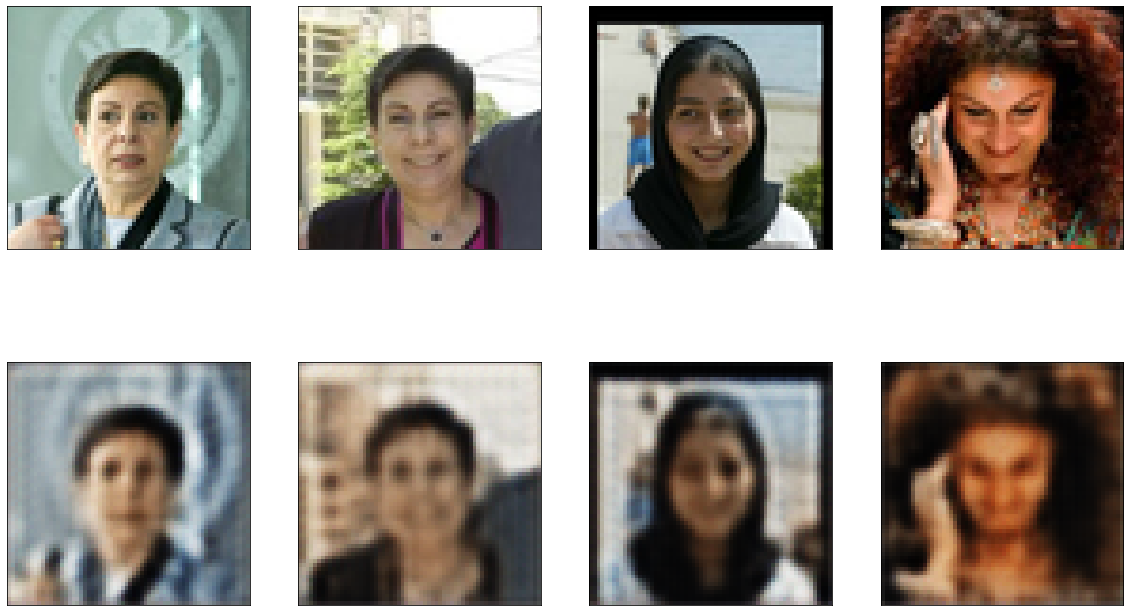

Running epoch 40/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:33 - loss: 0.0090 - acc: 0.745 - ETA: 2:27 - loss: 0.0091 - acc: 0.741 - ETA: 2:24 - loss: 0.0091 - acc: 0.739 - ETA: 2:19 - loss: 0.0092 - acc: 0.738 - ETA: 2:17 - loss: 0.0092 - acc: 0.737 - ETA: 2:15 - loss: 0.0092 - acc: 0.734 - ETA: 2:12 - loss: 0.0093 - acc: 0.735 - ETA: 2:08 - loss: 0.0092 - acc: 0.735 - ETA: 2:05 - loss: 0.0092 - acc: 0.735 - ETA: 2:02 - loss: 0.0093 - acc: 0.734 - ETA: 1:58 - loss: 0.0093 - acc: 0.735 - ETA: 1:54 - loss: 0.0093 - acc: 0.733 - ETA: 1:49 - loss: 0.0092 - acc: 0.731 - ETA: 1:45 - loss: 0.0092 - acc: 0.730 - ETA: 1:40 - loss: 0.0091 - acc: 0.731 - ETA: 1:36 - loss: 0.0091 - acc: 0.732 - ETA: 1:31 - loss: 0.0090 - acc: 0.734 - ETA: 1:27 - loss: 0.0089 - acc: 0.735 - ETA: 1:23 - loss: 0.0089 - acc: 0.736 - ETA: 1:19 - loss: 0.0088 - acc: 0.736 - ETA: 1:14 - loss: 0.0088 - acc: 0.737 - ETA: 1:10 - loss: 0.0087 - acc: 0.738 - ETA: 1:06 - loss: 0.0087 - acc: 0.738 - ETA: 

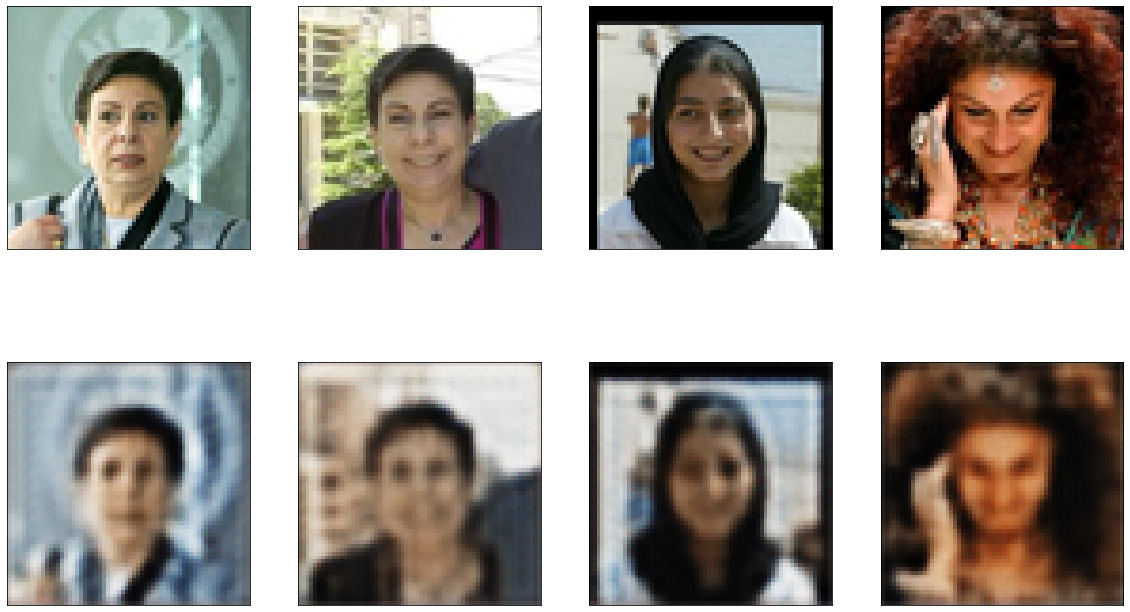

Running epoch 41/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:46 - loss: 0.0075 - acc: 0.739 - ETA: 2:35 - loss: 0.0076 - acc: 0.731 - ETA: 2:30 - loss: 0.0077 - acc: 0.732 - ETA: 2:24 - loss: 0.0078 - acc: 0.730 - ETA: 2:20 - loss: 0.0078 - acc: 0.736 - ETA: 2:15 - loss: 0.0078 - acc: 0.732 - ETA: 2:10 - loss: 0.0079 - acc: 0.735 - ETA: 2:05 - loss: 0.0080 - acc: 0.738 - ETA: 2:01 - loss: 0.0081 - acc: 0.741 - ETA: 1:57 - loss: 0.0081 - acc: 0.741 - ETA: 1:52 - loss: 0.0082 - acc: 0.742 - ETA: 1:48 - loss: 0.0082 - acc: 0.742 - ETA: 1:44 - loss: 0.0083 - acc: 0.742 - ETA: 1:40 - loss: 0.0083 - acc: 0.742 - ETA: 1:36 - loss: 0.0084 - acc: 0.741 - ETA: 1:32 - loss: 0.0084 - acc: 0.741 - ETA: 1:28 - loss: 0.0084 - acc: 0.742 - ETA: 1:24 - loss: 0.0084 - acc: 0.742 - ETA: 1:21 - loss: 0.0084 - acc: 0.742 - ETA: 1:17 - loss: 0.0084 - acc: 0.741 - ETA: 1:13 - loss: 0.0084 - acc: 0.741 - ETA: 1:09 - loss: 0.0084 - acc: 0.741 - ETA: 1:05 - loss: 0.0084 - acc: 0.742 - ETA: 

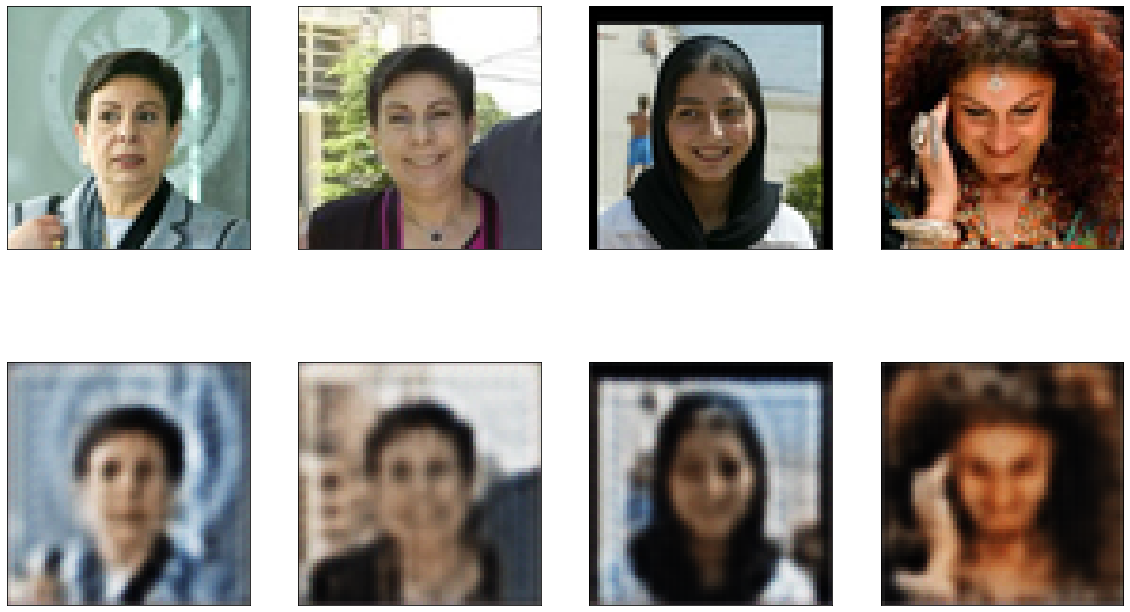

Running epoch 42/50
Epoch 1/1
5000/5000 [==============================] - ETA: 2:40 - loss: 0.0090 - acc: 0.711 - ETA: 2:32 - loss: 0.0091 - acc: 0.719 - ETA: 2:27 - loss: 0.0089 - acc: 0.724 - ETA: 2:24 - loss: 0.0088 - acc: 0.731 - ETA: 2:19 - loss: 0.0087 - acc: 0.733 - ETA: 2:15 - loss: 0.0088 - acc: 0.734 - ETA: 2:11 - loss: 0.0087 - acc: 0.739 - ETA: 2:07 - loss: 0.0086 - acc: 0.744 - ETA: 2:02 - loss: 0.0085 - acc: 0.745 - ETA: 1:58 - loss: 0.0085 - acc: 0.747 - ETA: 1:53 - loss: 0.0084 - acc: 0.746 - ETA: 1:50 - loss: 0.0084 - acc: 0.746 - ETA: 1:46 - loss: 0.0084 - acc: 0.746 - ETA: 1:41 - loss: 0.0084 - acc: 0.746 - ETA: 1:37 - loss: 0.0084 - acc: 0.747 - ETA: 1:35 - loss: 0.0084 - acc: 0.745 - ETA: 1:33 - loss: 0.0084 - acc: 0.744 - ETA: 1:30 - loss: 0.0084 - acc: 0.745 - ETA: 1:27 - loss: 0.0084 - acc: 0.744 - ETA: 1:24 - loss: 0.0084 - acc: 0.742 - ETA: 1:21 - loss: 0.0084 - acc: 0.742 - ETA: 1:17 - loss: 0.0084 - acc: 0.741 - ETA: 1:13 - loss: 0.0084 - acc: 0.741 - ETA: 

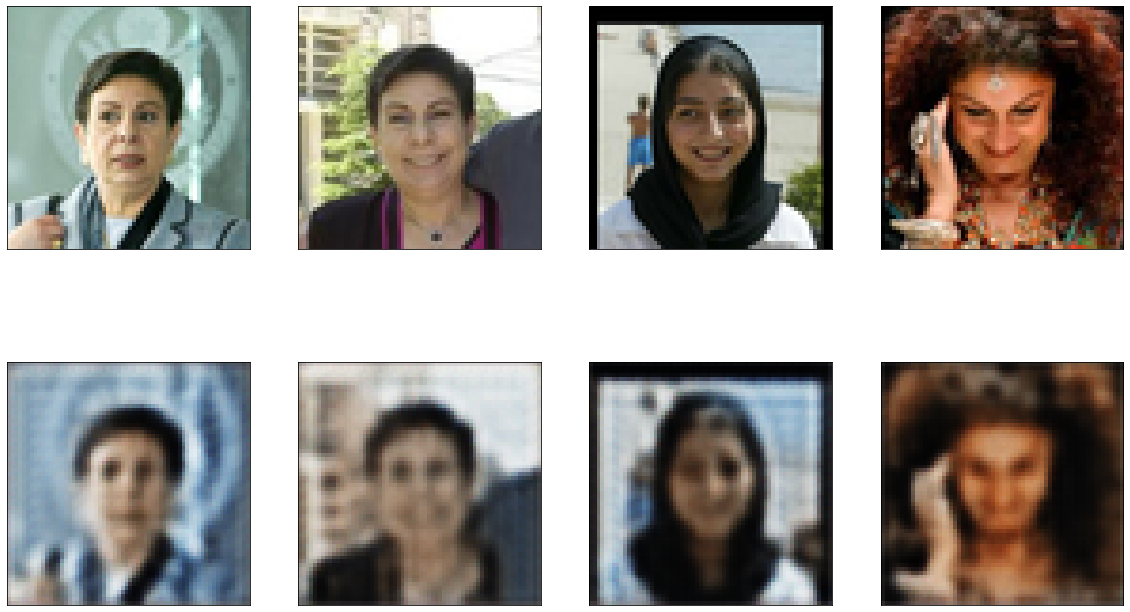

Running epoch 43/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:44 - loss: 0.0091 - acc: 0.728 - ETA: 3:33 - loss: 0.0090 - acc: 0.730 - ETA: 3:26 - loss: 0.0088 - acc: 0.733 - ETA: 3:20 - loss: 0.0087 - acc: 0.737 - ETA: 3:13 - loss: 0.0087 - acc: 0.735 - ETA: 3:07 - loss: 0.0087 - acc: 0.737 - ETA: 3:01 - loss: 0.0086 - acc: 0.740 - ETA: 2:55 - loss: 0.0085 - acc: 0.740 - ETA: 2:50 - loss: 0.0085 - acc: 0.742 - ETA: 2:45 - loss: 0.0085 - acc: 0.739 - ETA: 2:39 - loss: 0.0084 - acc: 0.738 - ETA: 2:33 - loss: 0.0084 - acc: 0.738 - ETA: 2:28 - loss: 0.0084 - acc: 0.738 - ETA: 2:22 - loss: 0.0083 - acc: 0.737 - ETA: 2:16 - loss: 0.0083 - acc: 0.736 - ETA: 2:10 - loss: 0.0083 - acc: 0.736 - ETA: 2:05 - loss: 0.0082 - acc: 0.735 - ETA: 1:59 - loss: 0.0082 - acc: 0.736 - ETA: 1:54 - loss: 0.0081 - acc: 0.737 - ETA: 1:48 - loss: 0.0081 - acc: 0.737 - ETA: 1:43 - loss: 0.0081 - acc: 0.736 - ETA: 1:37 - loss: 0.0080 - acc: 0.736 - ETA: 1:32 - loss: 0.0080 - acc: 0.736 - ETA: 

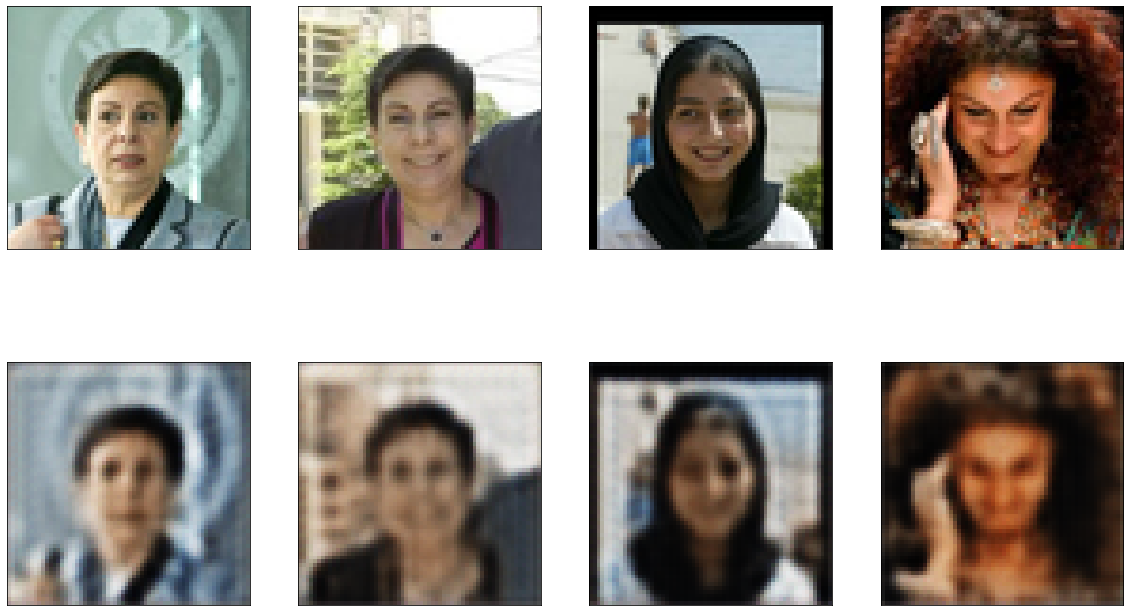

Running epoch 44/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:44 - loss: 0.0094 - acc: 0.731 - ETA: 3:34 - loss: 0.0093 - acc: 0.739 - ETA: 3:26 - loss: 0.0092 - acc: 0.738 - ETA: 3:19 - loss: 0.0090 - acc: 0.739 - ETA: 3:14 - loss: 0.0089 - acc: 0.741 - ETA: 3:07 - loss: 0.0088 - acc: 0.743 - ETA: 3:02 - loss: 0.0088 - acc: 0.744 - ETA: 2:56 - loss: 0.0087 - acc: 0.745 - ETA: 2:52 - loss: 0.0087 - acc: 0.745 - ETA: 2:47 - loss: 0.0086 - acc: 0.746 - ETA: 2:41 - loss: 0.0086 - acc: 0.747 - ETA: 2:35 - loss: 0.0086 - acc: 0.748 - ETA: 2:30 - loss: 0.0085 - acc: 0.749 - ETA: 2:24 - loss: 0.0085 - acc: 0.749 - ETA: 2:18 - loss: 0.0085 - acc: 0.747 - ETA: 2:12 - loss: 0.0085 - acc: 0.747 - ETA: 2:09 - loss: 0.0085 - acc: 0.747 - ETA: 2:04 - loss: 0.0085 - acc: 0.747 - ETA: 1:58 - loss: 0.0085 - acc: 0.748 - ETA: 1:52 - loss: 0.0084 - acc: 0.747 - ETA: 1:46 - loss: 0.0084 - acc: 0.747 - ETA: 1:40 - loss: 0.0084 - acc: 0.746 - ETA: 1:34 - loss: 0.0084 - acc: 0.745 - ETA: 

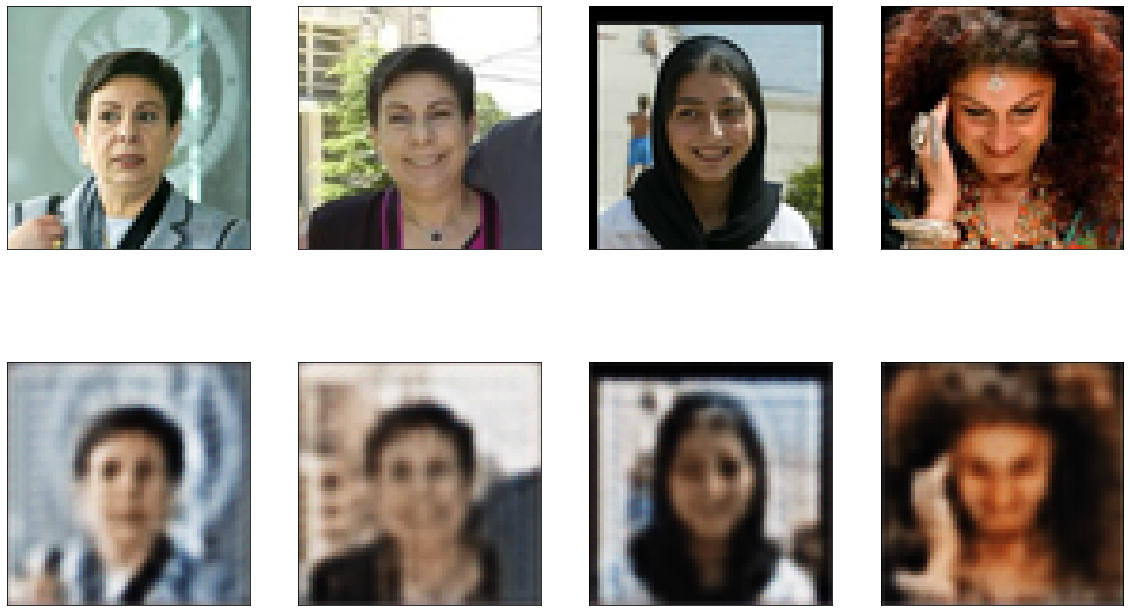

Running epoch 45/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:39 - loss: 0.0077 - acc: 0.728 - ETA: 3:30 - loss: 0.0074 - acc: 0.727 - ETA: 3:24 - loss: 0.0074 - acc: 0.730 - ETA: 3:18 - loss: 0.0074 - acc: 0.739 - ETA: 3:12 - loss: 0.0074 - acc: 0.746 - ETA: 3:07 - loss: 0.0075 - acc: 0.749 - ETA: 3:02 - loss: 0.0075 - acc: 0.751 - ETA: 2:56 - loss: 0.0076 - acc: 0.748 - ETA: 2:50 - loss: 0.0076 - acc: 0.747 - ETA: 2:45 - loss: 0.0077 - acc: 0.747 - ETA: 2:39 - loss: 0.0077 - acc: 0.747 - ETA: 2:34 - loss: 0.0077 - acc: 0.746 - ETA: 2:28 - loss: 0.0078 - acc: 0.747 - ETA: 2:22 - loss: 0.0078 - acc: 0.746 - ETA: 2:17 - loss: 0.0078 - acc: 0.747 - ETA: 2:11 - loss: 0.0079 - acc: 0.747 - ETA: 2:05 - loss: 0.0079 - acc: 0.747 - ETA: 1:59 - loss: 0.0080 - acc: 0.748 - ETA: 1:54 - loss: 0.0080 - acc: 0.747 - ETA: 1:48 - loss: 0.0081 - acc: 0.747 - ETA: 1:43 - loss: 0.0081 - acc: 0.745 - ETA: 1:37 - loss: 0.0082 - acc: 0.743 - ETA: 1:31 - loss: 0.0083 - acc: 0.743 - ETA: 

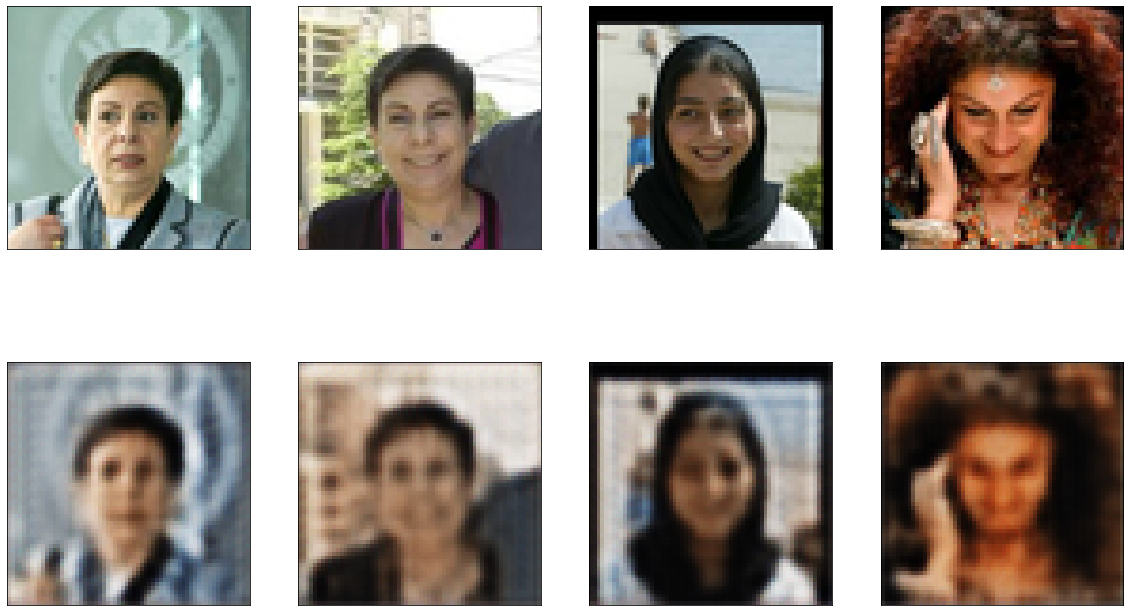

Running epoch 46/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:42 - loss: 0.0095 - acc: 0.751 - ETA: 3:33 - loss: 0.0092 - acc: 0.742 - ETA: 3:25 - loss: 0.0093 - acc: 0.745 - ETA: 3:18 - loss: 0.0092 - acc: 0.750 - ETA: 3:13 - loss: 0.0092 - acc: 0.751 - ETA: 3:07 - loss: 0.0091 - acc: 0.752 - ETA: 3:02 - loss: 0.0091 - acc: 0.750 - ETA: 2:56 - loss: 0.0091 - acc: 0.749 - ETA: 2:50 - loss: 0.0091 - acc: 0.747 - ETA: 2:44 - loss: 0.0092 - acc: 0.744 - ETA: 2:38 - loss: 0.0092 - acc: 0.742 - ETA: 2:33 - loss: 0.0092 - acc: 0.741 - ETA: 2:27 - loss: 0.0091 - acc: 0.740 - ETA: 2:21 - loss: 0.0090 - acc: 0.741 - ETA: 2:15 - loss: 0.0090 - acc: 0.742 - ETA: 2:10 - loss: 0.0089 - acc: 0.741 - ETA: 2:04 - loss: 0.0089 - acc: 0.741 - ETA: 1:59 - loss: 0.0088 - acc: 0.742 - ETA: 1:53 - loss: 0.0088 - acc: 0.742 - ETA: 1:48 - loss: 0.0087 - acc: 0.742 - ETA: 1:42 - loss: 0.0087 - acc: 0.742 - ETA: 1:36 - loss: 0.0086 - acc: 0.742 - ETA: 1:31 - loss: 0.0086 - acc: 0.742 - ETA: 

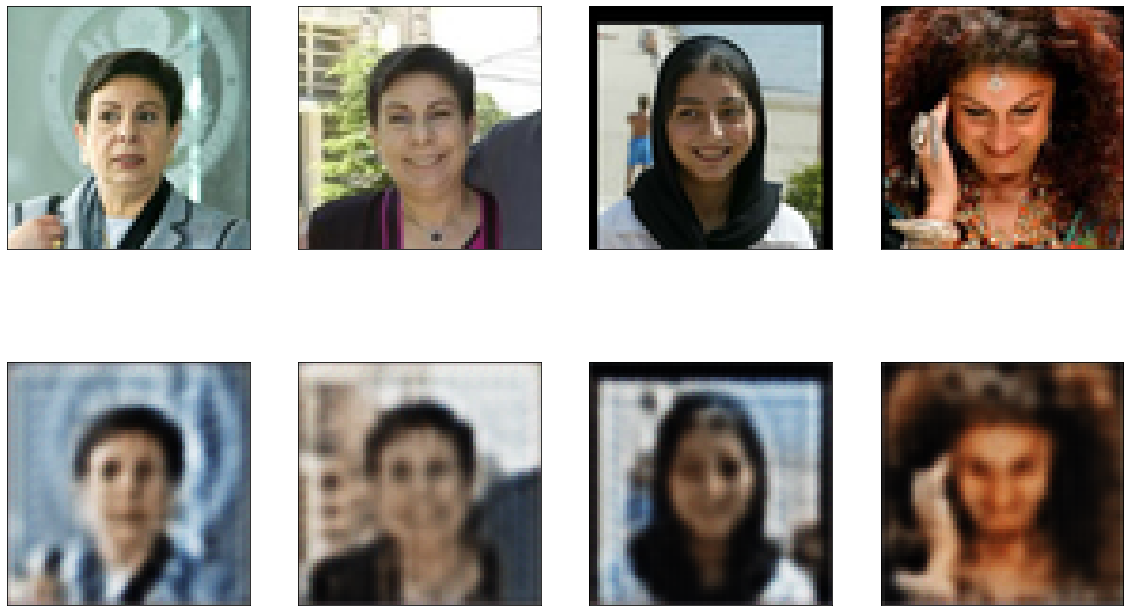

Running epoch 47/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:43 - loss: 0.0088 - acc: 0.715 - ETA: 3:32 - loss: 0.0090 - acc: 0.727 - ETA: 3:25 - loss: 0.0089 - acc: 0.730 - ETA: 3:21 - loss: 0.0089 - acc: 0.734 - ETA: 3:14 - loss: 0.0088 - acc: 0.735 - ETA: 3:08 - loss: 0.0088 - acc: 0.734 - ETA: 3:02 - loss: 0.0087 - acc: 0.736 - ETA: 2:56 - loss: 0.0087 - acc: 0.738 - ETA: 2:50 - loss: 0.0087 - acc: 0.738 - ETA: 2:44 - loss: 0.0086 - acc: 0.742 - ETA: 2:38 - loss: 0.0086 - acc: 0.742 - ETA: 2:33 - loss: 0.0086 - acc: 0.742 - ETA: 2:27 - loss: 0.0085 - acc: 0.742 - ETA: 2:21 - loss: 0.0085 - acc: 0.742 - ETA: 2:16 - loss: 0.0084 - acc: 0.743 - ETA: 2:10 - loss: 0.0084 - acc: 0.742 - ETA: 2:04 - loss: 0.0083 - acc: 0.742 - ETA: 1:59 - loss: 0.0083 - acc: 0.742 - ETA: 1:53 - loss: 0.0083 - acc: 0.742 - ETA: 1:47 - loss: 0.0082 - acc: 0.742 - ETA: 1:42 - loss: 0.0082 - acc: 0.742 - ETA: 1:36 - loss: 0.0082 - acc: 0.741 - ETA: 1:31 - loss: 0.0082 - acc: 0.741 - ETA: 

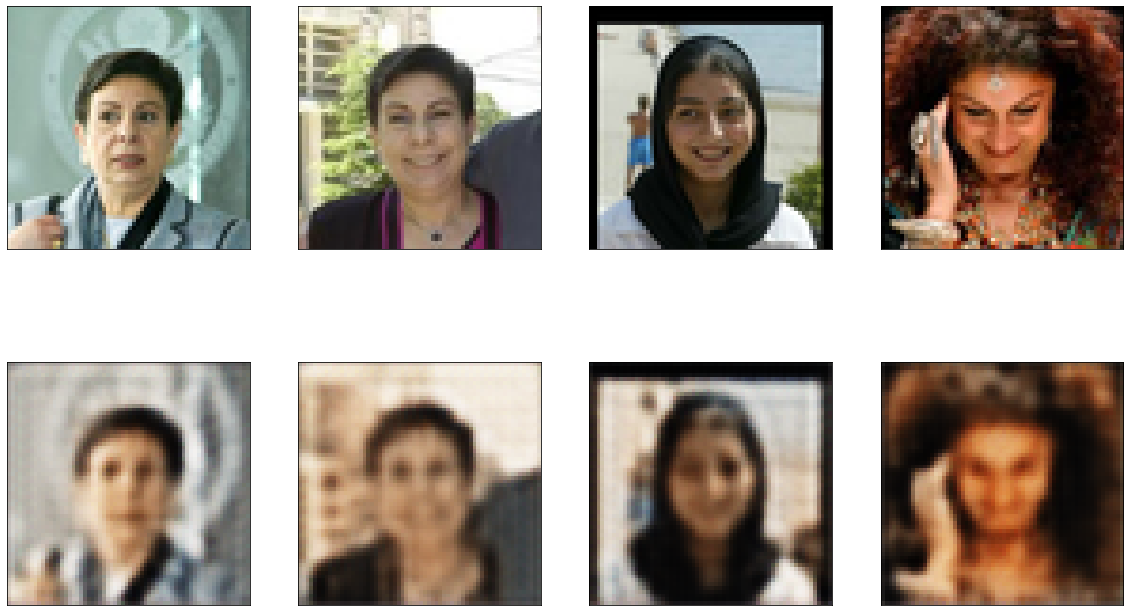

Running epoch 48/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:48 - loss: 0.0079 - acc: 0.734 - ETA: 3:36 - loss: 0.0078 - acc: 0.712 - ETA: 3:29 - loss: 0.0078 - acc: 0.713 - ETA: 3:21 - loss: 0.0077 - acc: 0.704 - ETA: 3:15 - loss: 0.0078 - acc: 0.702 - ETA: 3:08 - loss: 0.0077 - acc: 0.708 - ETA: 3:02 - loss: 0.0078 - acc: 0.713 - ETA: 2:57 - loss: 0.0078 - acc: 0.716 - ETA: 2:53 - loss: 0.0078 - acc: 0.719 - ETA: 2:47 - loss: 0.0079 - acc: 0.722 - ETA: 2:41 - loss: 0.0080 - acc: 0.723 - ETA: 2:35 - loss: 0.0080 - acc: 0.726 - ETA: 2:29 - loss: 0.0081 - acc: 0.727 - ETA: 2:23 - loss: 0.0081 - acc: 0.729 - ETA: 2:17 - loss: 0.0081 - acc: 0.728 - ETA: 2:12 - loss: 0.0082 - acc: 0.729 - ETA: 2:07 - loss: 0.0082 - acc: 0.730 - ETA: 2:01 - loss: 0.0082 - acc: 0.731 - ETA: 1:55 - loss: 0.0083 - acc: 0.733 - ETA: 1:49 - loss: 0.0083 - acc: 0.733 - ETA: 1:43 - loss: 0.0083 - acc: 0.735 - ETA: 1:38 - loss: 0.0083 - acc: 0.735 - ETA: 1:32 - loss: 0.0084 - acc: 0.734 - ETA: 

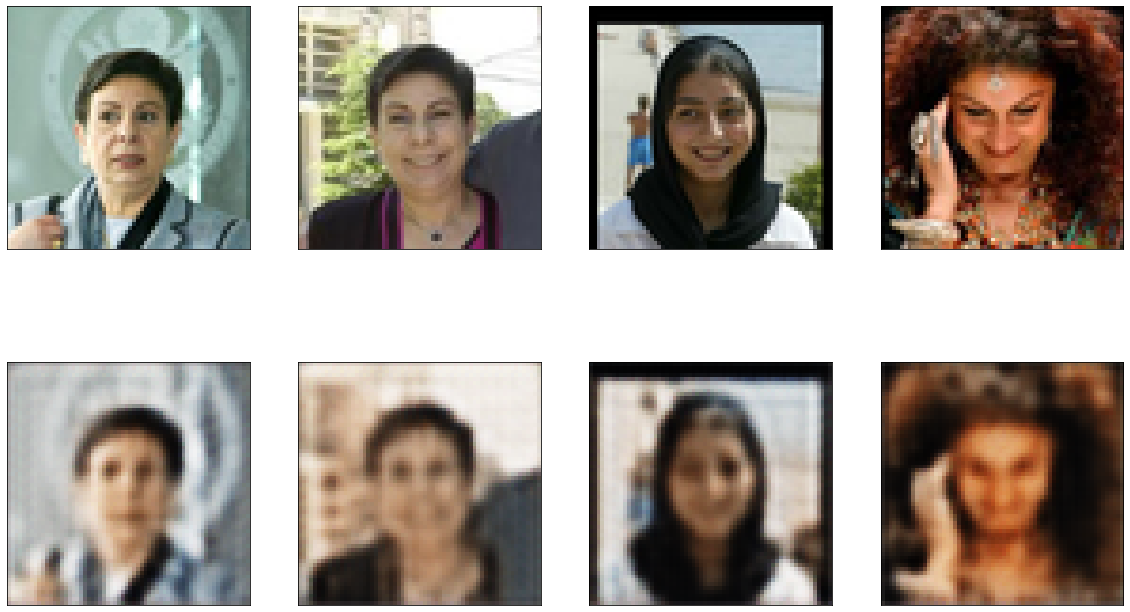

Running epoch 49/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:39 - loss: 0.0077 - acc: 0.752 - ETA: 3:31 - loss: 0.0078 - acc: 0.736 - ETA: 3:26 - loss: 0.0078 - acc: 0.734 - ETA: 3:20 - loss: 0.0079 - acc: 0.730 - ETA: 3:14 - loss: 0.0079 - acc: 0.730 - ETA: 3:07 - loss: 0.0078 - acc: 0.730 - ETA: 3:01 - loss: 0.0078 - acc: 0.732 - ETA: 2:56 - loss: 0.0077 - acc: 0.732 - ETA: 2:50 - loss: 0.0076 - acc: 0.734 - ETA: 2:45 - loss: 0.0075 - acc: 0.734 - ETA: 2:39 - loss: 0.0075 - acc: 0.734 - ETA: 2:34 - loss: 0.0075 - acc: 0.734 - ETA: 2:28 - loss: 0.0075 - acc: 0.735 - ETA: 2:22 - loss: 0.0074 - acc: 0.735 - ETA: 2:17 - loss: 0.0074 - acc: 0.736 - ETA: 2:11 - loss: 0.0074 - acc: 0.736 - ETA: 2:05 - loss: 0.0074 - acc: 0.737 - ETA: 1:59 - loss: 0.0074 - acc: 0.737 - ETA: 1:54 - loss: 0.0073 - acc: 0.737 - ETA: 1:48 - loss: 0.0074 - acc: 0.736 - ETA: 1:42 - loss: 0.0073 - acc: 0.736 - ETA: 1:36 - loss: 0.0073 - acc: 0.735 - ETA: 1:31 - loss: 0.0073 - acc: 0.735 - ETA: 

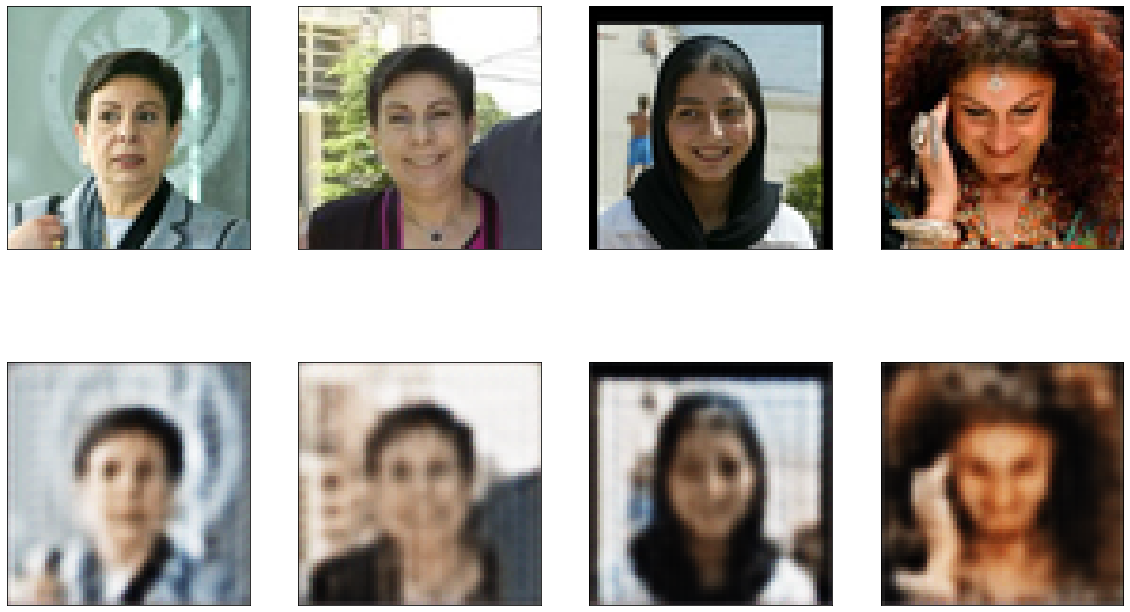

Running epoch 50/50
Epoch 1/1
5000/5000 [==============================] - ETA: 3:43 - loss: 0.0092 - acc: 0.749 - ETA: 3:33 - loss: 0.0094 - acc: 0.756 - ETA: 3:27 - loss: 0.0092 - acc: 0.750 - ETA: 3:21 - loss: 0.0091 - acc: 0.748 - ETA: 3:14 - loss: 0.0091 - acc: 0.749 - ETA: 3:08 - loss: 0.0091 - acc: 0.747 - ETA: 3:02 - loss: 0.0090 - acc: 0.749 - ETA: 2:56 - loss: 0.0090 - acc: 0.750 - ETA: 2:50 - loss: 0.0089 - acc: 0.749 - ETA: 2:45 - loss: 0.0088 - acc: 0.750 - ETA: 2:39 - loss: 0.0088 - acc: 0.749 - ETA: 2:33 - loss: 0.0087 - acc: 0.750 - ETA: 2:27 - loss: 0.0086 - acc: 0.749 - ETA: 2:22 - loss: 0.0086 - acc: 0.750 - ETA: 2:16 - loss: 0.0085 - acc: 0.750 - ETA: 2:11 - loss: 0.0085 - acc: 0.749 - ETA: 2:05 - loss: 0.0085 - acc: 0.746 - ETA: 2:00 - loss: 0.0084 - acc: 0.745 - ETA: 1:54 - loss: 0.0084 - acc: 0.744 - ETA: 1:48 - loss: 0.0084 - acc: 0.744 - ETA: 1:42 - loss: 0.0084 - acc: 0.745 - ETA: 1:37 - loss: 0.0084 - acc: 0.745 - ETA: 1:31 - loss: 0.0084 - acc: 0.745 - ETA: 

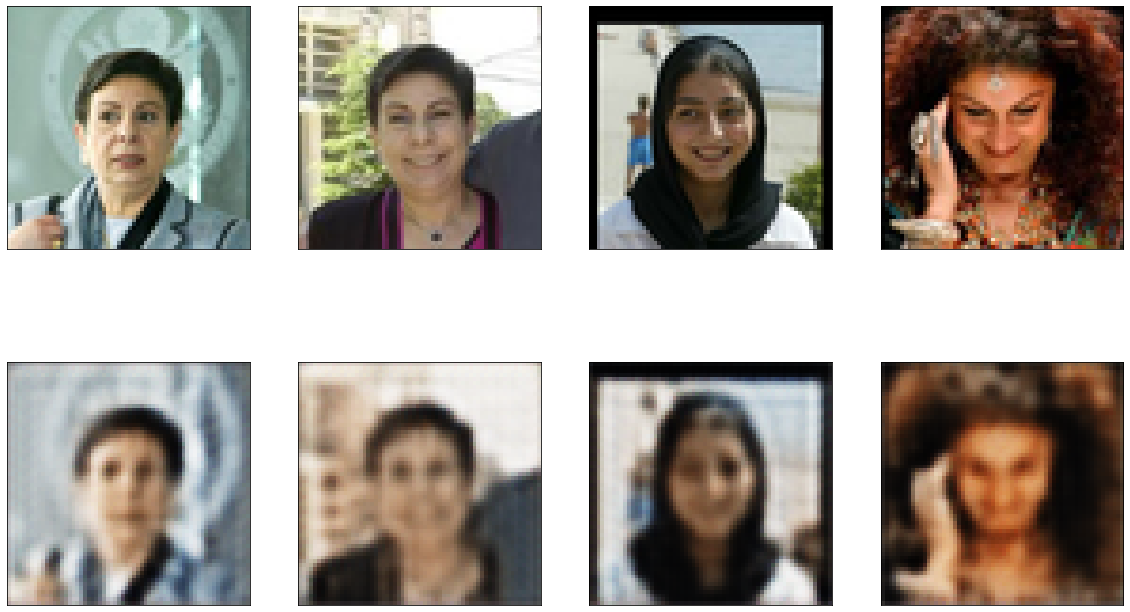

In [25]:
from keras.callbacks import CSVLogger
TRAINING_LOGS_FILE = 'auto_resnet-0001-50plusep.csv'
epochs=50
history = {}
for j in range(epochs):
    print(f'Running epoch {j+1}/{epochs}')
    doggifier.fit(x_train, x_train,
                epochs=1,
                batch_size=128,
                shuffle=True,
                callbacks=[ CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")])
    epoch_number = j+1
    history[epoch_number] = doggifier.history.history
    decoded_imgs = doggifier.predict(x_test)
    
    n = 4
    plt.figure(figsize=(20, 12))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(decoded_imgs[i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    fig_name = f'fig_epoch{j}-res-again-scnd50-0001.png'
    plt.savefig(fig_name)
    plt.show()

In [26]:
doggifier.save('doggif_res-again-scd50-0001.h5')

In [52]:
decoded_imgs2 = doggifier.predict(x_test)

In [54]:
decoded_imgs2.shape

(1000, 64, 64, 3)

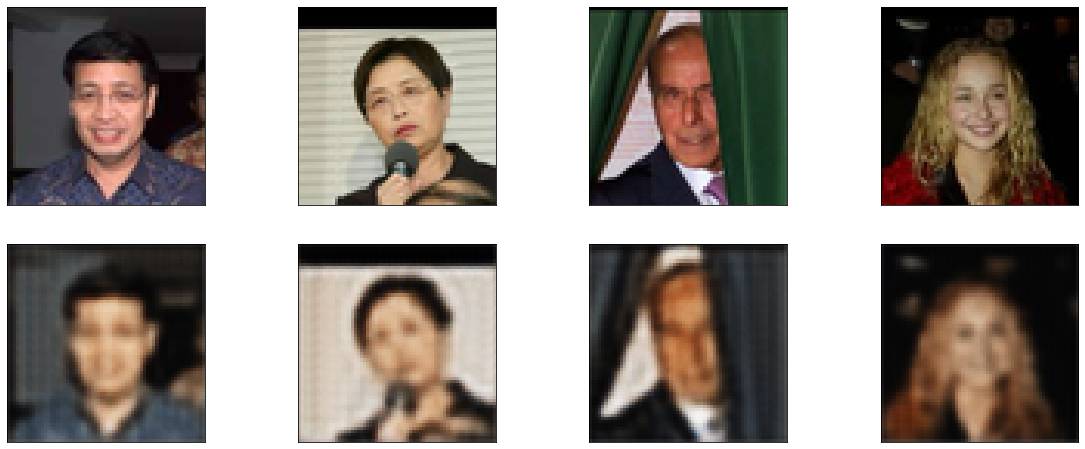

In [53]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+100].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i +1 + n)
    plt.imshow(decoded_imgs2[i+100].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
import os 

def get_training_data(datafolder):
        print("Loading training data...")

        training_data = []
        #Finds all files in datafolder
        foldernames = os.listdir(datafolder)
#         print(foldernames)
        for foldername in tqdm(foldernames):
            folder_path = os.path.join(datafolder, foldername)
            filenames = os.listdir(folder_path)
            folder = foldername
            for filename in tqdm(filenames):
                
                #Combines folder name and file name.
                path = os.path.join(datafolder,folder, filename)
                print(path)
                
                #Opens an image as an Image object.
                image = Image.open(path)
                
                #Resizes to a desired size.
                image = image.resize((64,64),Image.ANTIALIAS)
                
                #Creates an array of pixel values from the image.
                pixel_array = np.asarray(image)
#                 print(type(pixel_array))
                print(pixel_array.shape)
                training_data.append(pixel_array)

        #training_data is converted to a numpy array
        training_data = np.asarray(training_data)
#         training_data = np.reshape(training_data,(-1,64,64,1))
        return training_data